In [1]:
import numpy as np
bases = ['A', 'C', 'G', 'T']
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

# Load data

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [3]:
phastcons = {}
with open('../anno/hg19.100way.phastCons.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phastcons: phastcons[chrom] = {}
        phastcons[chrom][int(pos)] = float(score)
phylop = {}
with open('../anno/hg19.100way.phyloP100way.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phylop: phylop[chrom] = {}
        phylop[chrom][int(pos)] = float(score)

In [4]:
# file result of bedtools intersect -loj
introns = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, _, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [5]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)

37110
169182


In [6]:
import pandas
mercer = pandas.ExcelFile('../anno/mercer.Supplemental_TableS1.xlsx')
print mercer.sheet_names
support = mercer.parse('Split-Invert Alignment')
supp = {}
for chrom, pos, strand in zip(support['Chromosome'], support['Start'], support['Strand']):
    if chrom not in supp: supp[chrom] = {}
    supp[chrom][pos] = 1

[u'Match Only', u'Match+Error', u'Match+Insertion', u'Match+Deletion', u'Split-Invert Alignment']


In [7]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

def encode(introns, phastcons, phylop):
    X, y_high, y_low, chroms, coords, strands = [], [], [], [], [], []
    for intron, bps in introns.items():
        chrom, three, strand = intron
        if strand == '+':
            begin, stop = three - L, three
        else:
            begin, stop = three, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        c1 = np.array([phastcons[chrom][pos] if pos in phastcons[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        c2 = np.array([phylop[chrom][pos] if pos in phylop[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        
        if strand == '-':
            c1 = c1[::-1]
            c2 = c2[::-1]
        X += [np.hstack([onehot(seq), c1, c2]).reshape(1, L, 6)]

        # Make target
        _y_high = np.zeros((stop - begin,))
        for bp in bps:
            assert int(bp) in supp[chrom]
            if strand == '+':
                bp = L + bp - three
            else:
                bp = L - bp + three - 1
            _y_high[bp] = 1
         
        _y_low = np.zeros((stop - begin,))
        for i in range(L):
            if strand == '+':
                coord = three - L + i
            else:
                coord = L - i + three - 1
            if (not _y_high[i]) and (coord in supp[chrom]):
                _y_low[i] = 1
        y_high += [_y_high]
        y_low  += [_y_low]
        
        chroms += [chrom]
        coords += [three]
        strands += [strand]
    return (np.vstack(X), np.vstack(y_high), np.vstack(y_low),
            np.array(chroms), np.array(coords), np.array(strands))

X, y_high, y_low, chroms, coords, strands = encode(known,
                                                   phastcons,
                                                   phylop)

coords = coords[chroms == 'chr1']
strands = strands[chroms == 'chr1']
print np.sum(y_high), np.sum(y_low)
print X.shape

56808.0 35895.0
(37110, 70, 6)


In [8]:
test = np.array(map(lambda x: x == 'chr1', chroms))
valid = np.array(map(lambda x: x in ('chr2', 'chr3', 'chr4', 'chr5'),
                     chroms))
train = np.array([not (t or v) for t, v in zip(test, valid)])
print sum(test),  sum(valid), sum(train)

X_train, X_valid, X_test = X[train], X[valid], X[test]
y_high_train, y_low_train = y_high[train], y_low[train]
y_high_valid, y_low_valid = y_high[valid], y_low[valid]
y_high_test, y_low_test   = y_high[test],  y_low[test]
print X_train.shape, X_valid.shape, X_test.shape
print y_high_train.shape, y_high_valid.shape, y_high_test.shape

4306 7093 25711
(25711, 70, 6) (7093, 70, 6) (4306, 70, 6)
(25711, 70) (7093, 70) (4306, 70)


# Load model

In [9]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

Using Theano backend.


In [10]:
test_preds = model.predict(X_test[:, :, :4]).reshape(-1, 70)

# Conservation

In [11]:
def match(p, t):
    return np.argmax(p) in np.nonzero(t)[0]

def close(p, t):
    return any(i in np.nonzero(t)[0]
               for i in range(np.argmax(p)+B, np.argmax(p)+E+1))

def use_pred(p, t):
    return [np.argmax(p)]

def use_second(p, t):
    bp = np.argmax(p)
    bp2 = np.argmax(np.hstack([p[:bp],
                               np.zeros((1,)),
                               p[bp+1:]]))
    return [bp2]

def match2(p, t, thresh):
    bp = np.argmax(p)
    bp2 = np.argmax(np.hstack([p[:bp],
                               np.zeros((1,)),
                               p[bp+1:]]))
    if p[bp2] < thresh: return False
    return bp2 in np.nonzero(t)[0]

def use_mercer(p, t):
    return np.nonzero(t)[0]

def cons(p, high, low, X, filt, getBP, c, label):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, h, l, seq in zip(test_preds, high, low, X_test):
        if not filt(target, h, l): continue
        for bp in getBP(target, h):
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            counts = counts + seq[bp-K: bp+K+1, c]
            total += 1
    plt.plot(range(-K, K+1), counts / total,
             label = "{} n={}".format(label, total))

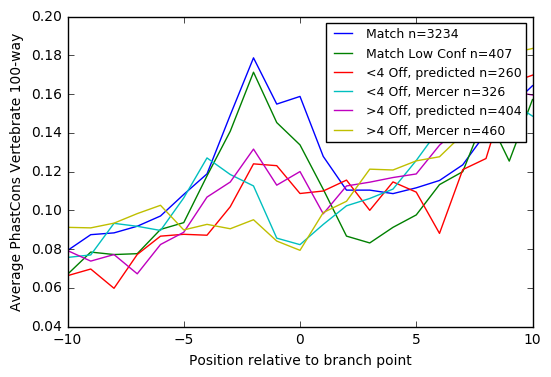

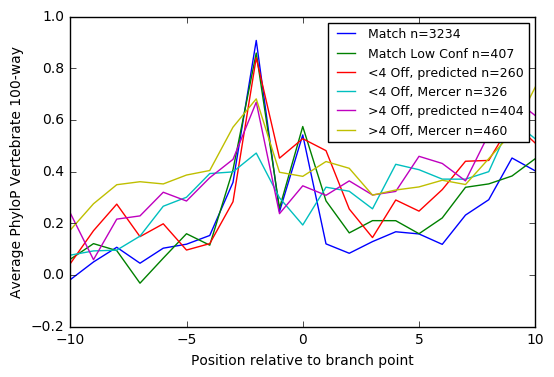

In [12]:
K = 10
B, E = -4, 4
for name, c in zip(['PhastCons', 'PhyloP'], [4, 5]):
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: match(x,y), use_pred,
         c, 'Match')
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: match(x,z), use_pred,
         c, 'Match Low Conf')
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: close(x, y) and not (match(x,y) or match(x,z)),
         use_pred,
         c, '<4 Off, predicted')
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: close(x, y) and not (match(x,y) or match(x,z)),
         use_mercer,
         c, '<4 Off, Mercer')
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: not (close(x, y) or match(x,y) or match(x,z)),
         use_pred,
         c, '>4 Off, predicted')
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: not (close(x, y) or match(x,y) or match(x,z)),
         use_mercer,
         c, '>4 Off, Mercer')
    plt.ylabel("Average {} Vertebrate 100-way".format(name))
    plt.xlabel('Position relative to branch point')
    plt.legend(loc = 1, prop={'size':9})
    plt.show()

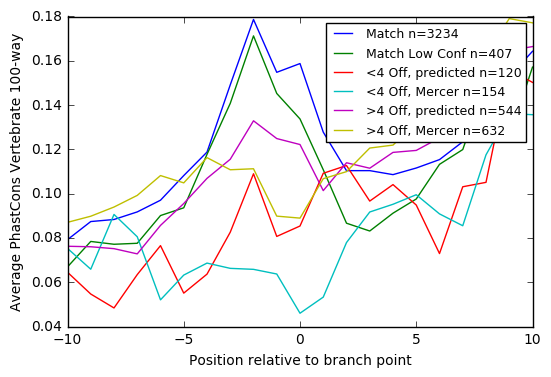

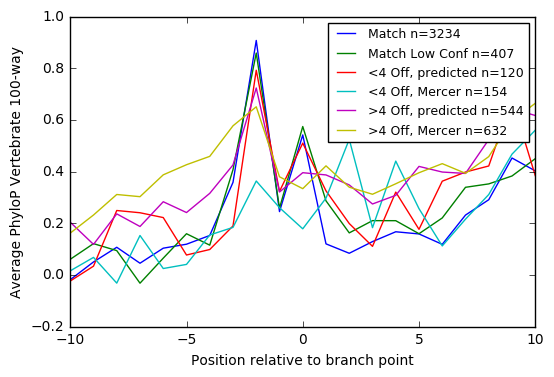

In [13]:
K = 10
B, E = -4, 0
for name, c in zip(['PhastCons', 'PhyloP'], [4, 5]):
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: match(x,y), use_pred,
         c, 'Match')
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: match(x,z), use_pred,
         c, 'Match Low Conf')
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: close(x, y) and not (match(x,y) or match(x,z)),
         use_pred,
         c, '<4 Off, predicted')
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: close(x, y) and not (match(x,y) or match(x,z)),
         use_mercer,
         c, '<4 Off, Mercer')
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: not (close(x, y) or match(x,y) or match(x,z)),
         use_pred,
         c, '>4 Off, predicted')
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: not (close(x, y) or match(x,y) or match(x,z)),
         use_mercer,
         c, '>4 Off, Mercer')
    plt.ylabel("Average {} Vertebrate 100-way".format(name))
    plt.xlabel('Position relative to branch point')
    plt.legend(loc = 1, prop={'size':9})
    plt.show()

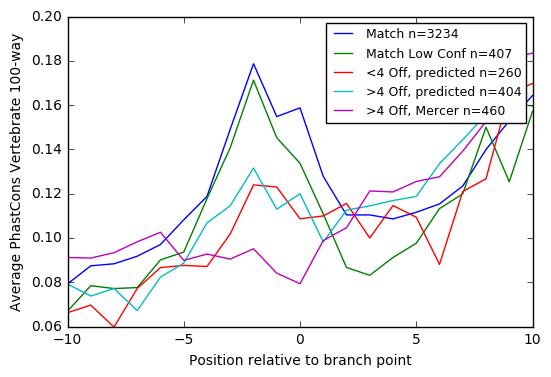

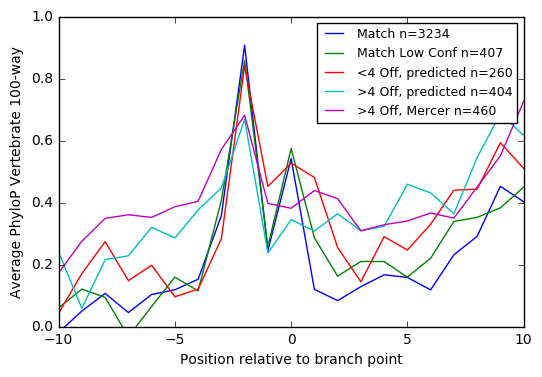

In [14]:
K = 10
B, E = -4, 4
for name, c in zip(['PhastCons', 'PhyloP'], [4, 5]):
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: match(x,y), use_pred,
         c, 'Match')
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: match(x,z), use_pred,
         c, 'Match Low Conf')
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: close(x, y) and not (match(x,y) or match(x,z)),
         use_pred,
         c, '<4 Off, predicted')
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: not (close(x, y) or match(x,y) or match(x,z)),
         use_pred,
         c, '>4 Off, predicted')
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: not (close(x, y) or match(x,y) or match(x,z)),
         use_mercer,
         c, '>4 Off, Mercer')
    plt.ylabel("Average {} Vertebrate 100-way".format(name))
    plt.xlabel('Position relative to branch point')
    plt.legend(loc = 1, prop={'size':9})
    if c == 4:
        plt.ylim(0.06)
    else:
        plt.ylim(0)
    plt.show()

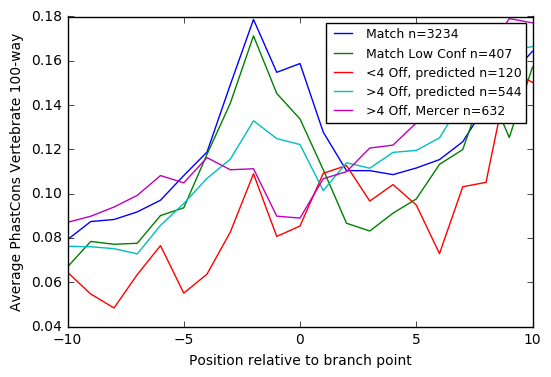

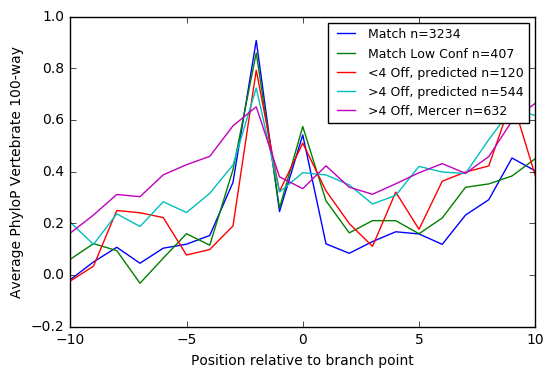

In [15]:
K = 10
B, E = -4, 0
for name, c in zip(['PhastCons', 'PhyloP'], [4, 5]):
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: match(x,y), use_pred,
         c, 'Match')
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: match(x,z), use_pred,
         c, 'Match Low Conf')
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: close(x, y) and not (match(x,y) or match(x,z)),
         use_pred,
         c, '<4 Off, predicted')
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: not (close(x, y) or match(x,y) or match(x,z)),
         use_pred,
         c, '>4 Off, predicted')
    cons(test_preds, y_high_test, y_low_test, X_test,
         lambda x,y,z: not (close(x, y) or match(x,y) or match(x,z)),
         use_mercer,
         c, '>4 Off, Mercer')
    plt.ylabel("Average {} Vertebrate 100-way".format(name))
    plt.xlabel('Position relative to branch point')
    plt.legend(loc = 1, prop={'size':9})
    plt.show()

# Distances

In [16]:
def dists(p, high, low, filt, getBP, label):
    counts = np.zeros((L,))
    total = 0
    for target, h, l, seq in zip(test_preds, high, low, X_test):
        if not filt(target, h, l): continue
        for bp in getBP(target, h):
            counts[bp] += 1
            total += 1
    plt.plot(range(-L, 0), counts / total,
             label = "{} n={}".format(label, total))

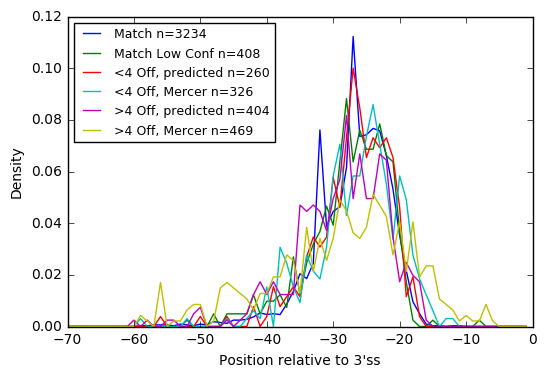

In [17]:
B, E = -4, 4
dists(test_preds,y_high_test, y_low_test, 
      lambda x,y,z: match(x,y), use_pred,
      'Match')
dists(test_preds, y_high_test, y_low_test, 
      lambda x,y,z: match(x,z), use_pred,
      'Match Low Conf')
dists(test_preds, y_high_test, y_low_test, 
      lambda x,y,z: close(x, y) and not (match(x,y) or match(x,z)),
      use_pred,
     '<4 Off, predicted')
dists(test_preds, y_high_test, y_low_test, 
      lambda x,y,z: close(x, y) and not (match(x,y) or match(x,z)),
      use_mercer,
      '<4 Off, Mercer')
dists(test_preds, y_high_test, y_low_test, 
      lambda x,y,z: not (close(x, y) or match(x,y) or match(x,z)),
      use_pred,
      '>4 Off, predicted')
dists(test_preds, y_high_test, y_low_test, 
      lambda x,y,z: not (close(x, y) or match(x,y) or match(x,z)),
      use_mercer,
      '>4 Off, Mercer')
plt.ylabel('Density')
plt.xlabel("Position relative to 3'ss")
plt.legend(loc = 2, prop={'size':9})
plt.show()

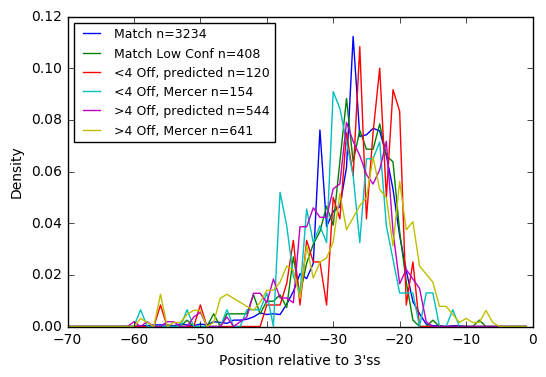

In [18]:
B, E = -4, 0
dists(test_preds,y_high_test, y_low_test, 
      lambda x,y,z: match(x,y), use_pred,
      'Match')
dists(test_preds, y_high_test, y_low_test, 
      lambda x,y,z: match(x,z), use_pred,
      'Match Low Conf')
dists(test_preds, y_high_test, y_low_test, 
      lambda x,y,z: close(x, y) and not (match(x,y) or match(x,z)),
      use_pred,
     '<4 Off, predicted')
dists(test_preds, y_high_test, y_low_test, 
      lambda x,y,z: close(x, y) and not (match(x,y) or match(x,z)),
      use_mercer,
      '<4 Off, Mercer')
dists(test_preds, y_high_test, y_low_test, 
      lambda x,y,z: not (close(x, y) or match(x,y) or match(x,z)),
      use_pred,
      '>4 Off, predicted')
dists(test_preds, y_high_test, y_low_test, 
      lambda x,y,z: not (close(x, y) or match(x,y) or match(x,z)),
      use_mercer,
      '>4 Off, Mercer')
plt.ylabel('Density')
plt.xlabel("Position relative to 3'ss")
plt.legend(loc = 2, prop={'size':9})
plt.show()

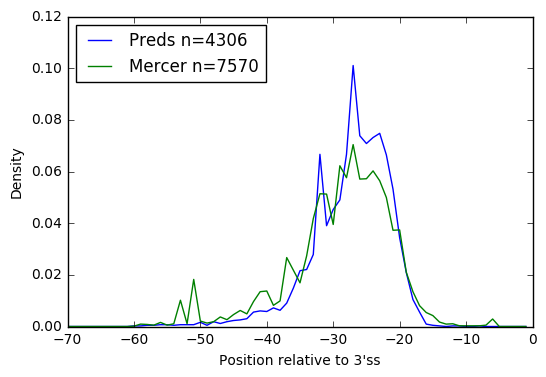

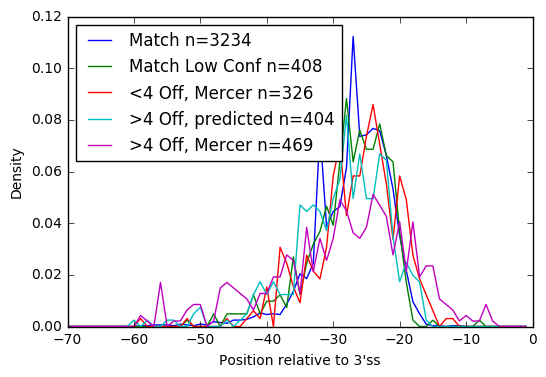

In [19]:
B, E = -4, 4
dists(test_preds,y_high_test, y_low_test, 
      lambda x,y,z: True, use_pred,
      'Preds')
dists(test_preds,y_high_test, y_low_test, 
      lambda x,y,z: True, use_mercer,
      'Mercer')
plt.ylabel('Density')
plt.xlabel("Position relative to 3'ss")
plt.legend(loc = 'best')
plt.show()
dists(test_preds,y_high_test, y_low_test, 
      lambda x,y,z: match(x,y), use_pred,
      'Match')
dists(test_preds, y_high_test, y_low_test, 
      lambda x,y,z: match(x,z), use_pred,
      'Match Low Conf')

dists(test_preds, y_high_test, y_low_test, 
      lambda x,y,z: close(x, y) and not (match(x,y) or match(x,z)),
      use_mercer,
      '<4 Off, Mercer')
dists(test_preds, y_high_test, y_low_test, 
      lambda x,y,z: not (close(x, y) or match(x,y) or match(x,z)),
      use_pred,
      '>4 Off, predicted')
dists(test_preds, y_high_test, y_low_test, 
      lambda x,y,z: not (close(x, y) or match(x,y) or match(x,z)),
      use_mercer,
      '>4 Off, Mercer')
plt.ylabel('Density')
plt.xlabel("Position relative to 3'ss")
plt.legend(loc = 'best')
plt.show()

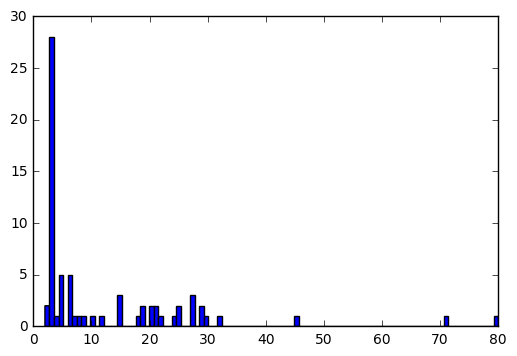

In [20]:
"""
I looked into this because of the jagged curves above.
I was worried that there would be repeated entries or something.
There are a small number of close 3'ss, but they are a minority.
"""
plt.hist([c2-c1
          for c1, c2 in zip(sorted(coords)[:-1], sorted(coords)[1:])
          if c2 - c1 < 100],
         bins = 100)
plt.show()

# PWMs

In [21]:
K = 5
def pwm_logo(pwm, title = ''):
    f, ax1 = plt.subplots(1, figsize=(10,5))
    bar_width = 0.75
    bar_l = [i+1 for i in range(pwm.shape[0])]
    tick_pos = [i+(bar_width/2) for i in bar_l]

    for i, (char, color) in enumerate(zip(['A', 'C', 'G', 'T'],
                                 ['r', 'c','g', 'b'])):
        # Create a bar plot, in position bar_1
        ax1.bar(bar_l,
                pwm[:, i],
                width=bar_width,
                label=char,
                bottom=np.sum(pwm[:, :i], axis = 1),
                alpha=0.5,
                color = color)
    plt.xticks(tick_pos, range(-K, K+1))
    plt.legend()
    plt.title(title)
    plt.ylim(0, 1)
    plt.xlim(0.75)
    plt.show()

def pwm(p, high, low, filt, getBP, title):
    counts = np.zeros((2*K+1, 4))
    total = 0
    for target, h, l, seq in zip(test_preds, high, low, X_test):
        if not filt(target, h, l): continue
        for bp in getBP(target, h):
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            counts = counts + seq[bp-K: bp+K+1, :4]
            total += 1
    pwm_logo(counts / total, title)

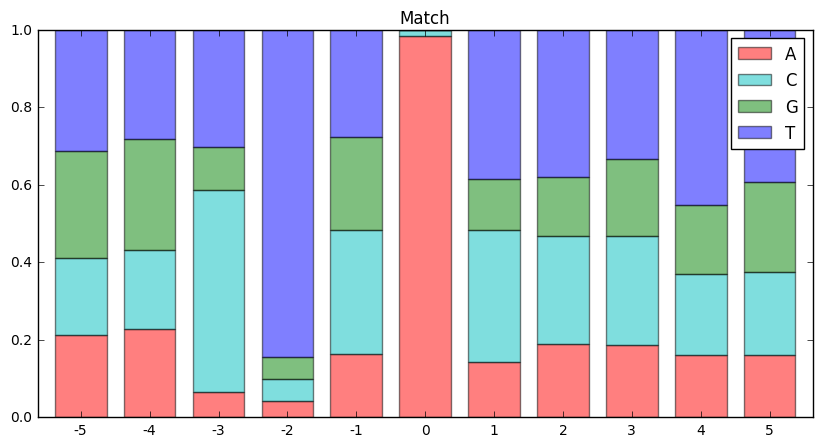

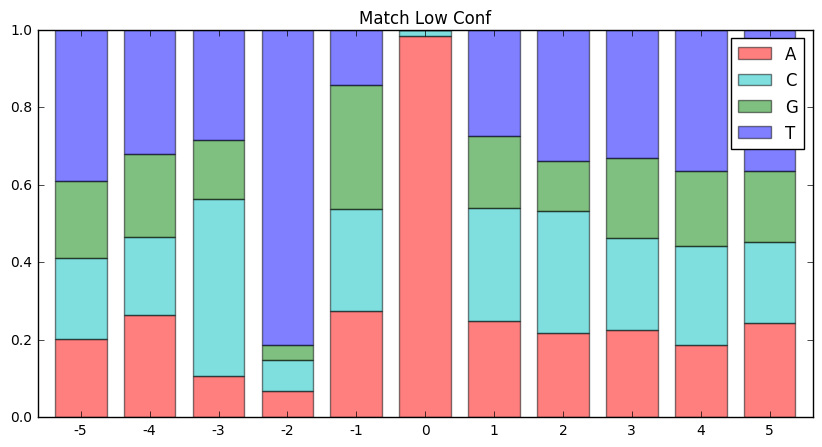

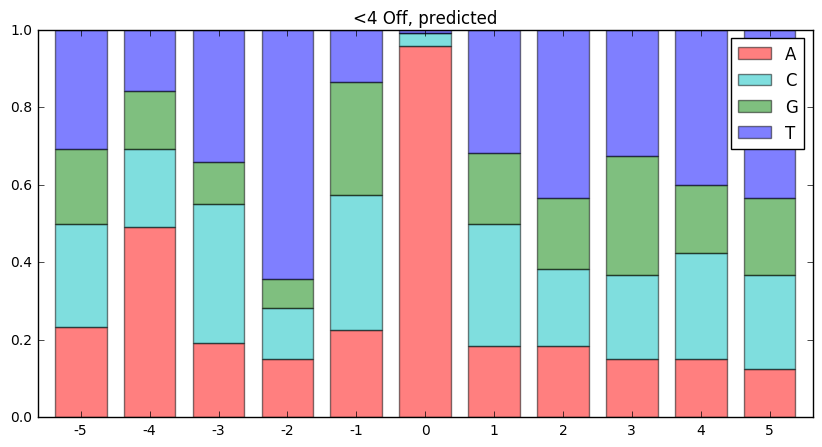

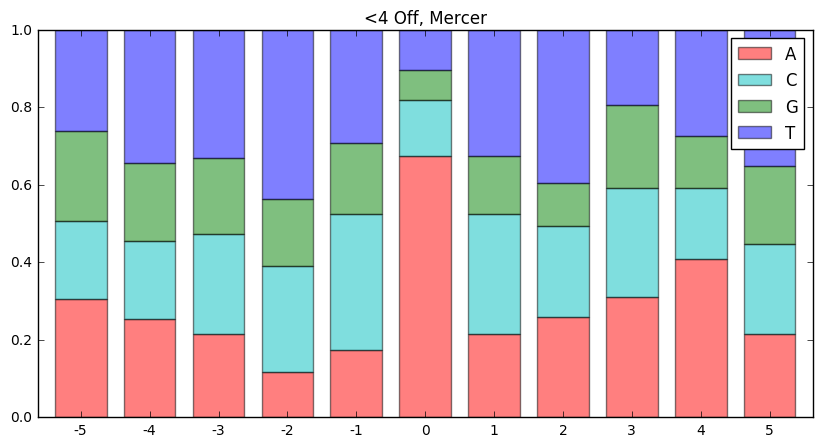

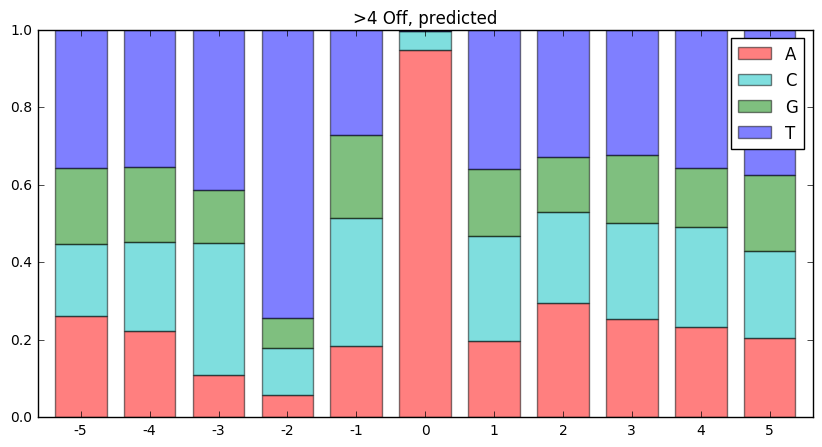

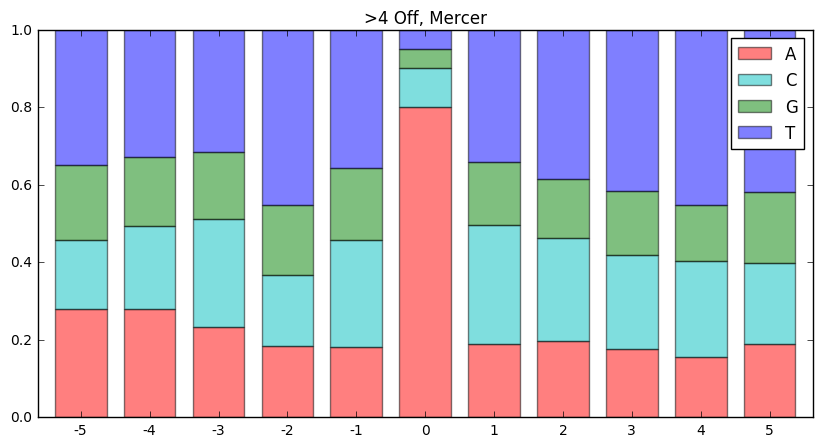

In [22]:
B, E = -4, 0
pwm(test_preds, y_high_test, y_low_test,
    lambda x,y,z: match(x,y), use_pred,
    'Match')
pwm(test_preds, y_high_test, y_low_test,
    lambda x,y,z: match(x,z), use_pred,
    'Match Low Conf')
pwm(test_preds, y_high_test, y_low_test,
    lambda x,y,z: close(x, y) and not (match(x,y) or match(x,z)),
    use_pred,
    '<4 Off, predicted')
pwm(test_preds, y_high_test, y_low_test,
    lambda x,y,z: close(x, y) and not (match(x,y) or match(x,z)),
    use_mercer,
    '<4 Off, Mercer')
pwm(test_preds, y_high_test, y_low_test,
    lambda x,y,z: not (close(x, y) or match(x,y) or match(x,z)),
    use_pred,
    '>4 Off, predicted')
pwm(test_preds, y_high_test, y_low_test,
    lambda x,y,z: not (close(x, y) or match(x,y) or match(x,z)),
    use_mercer,
    '>4 Off, Mercer')

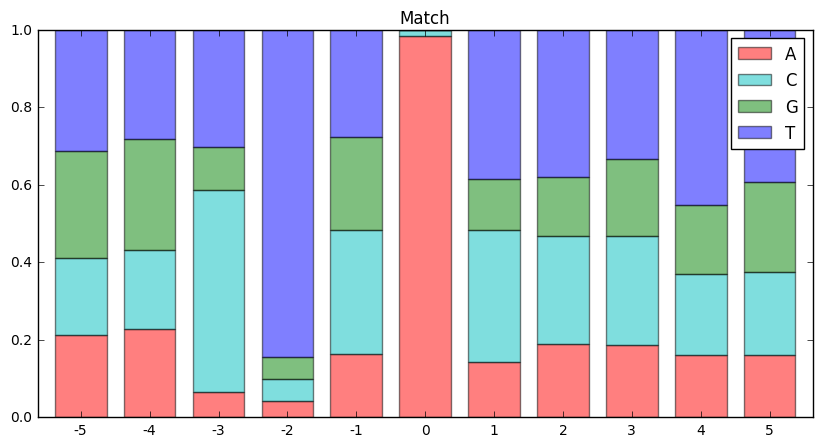

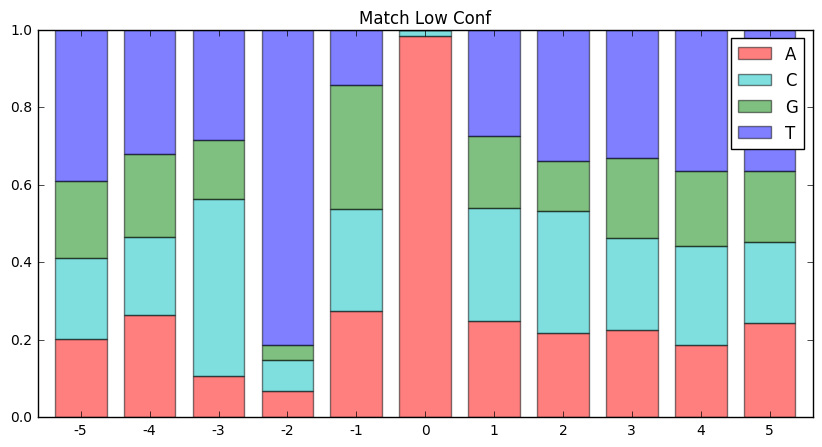

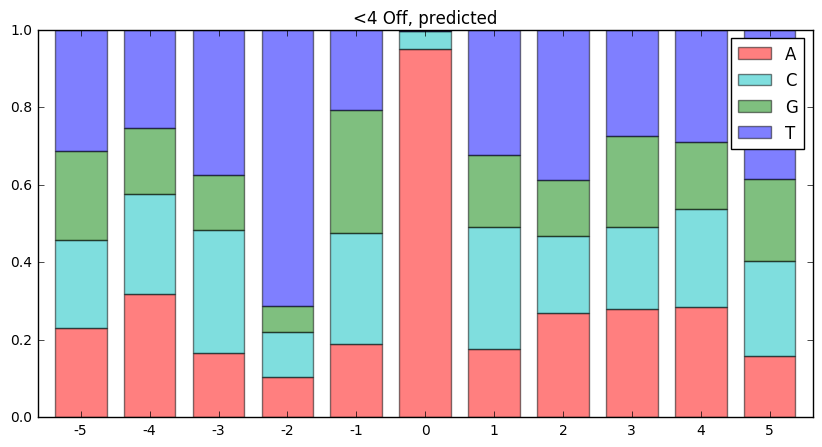

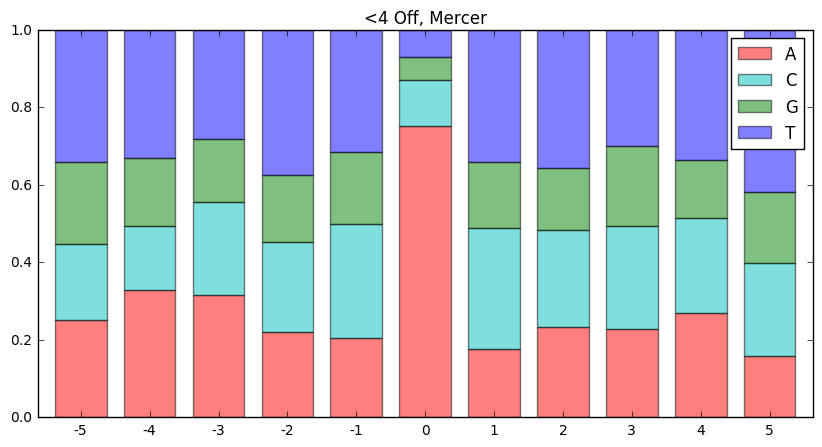

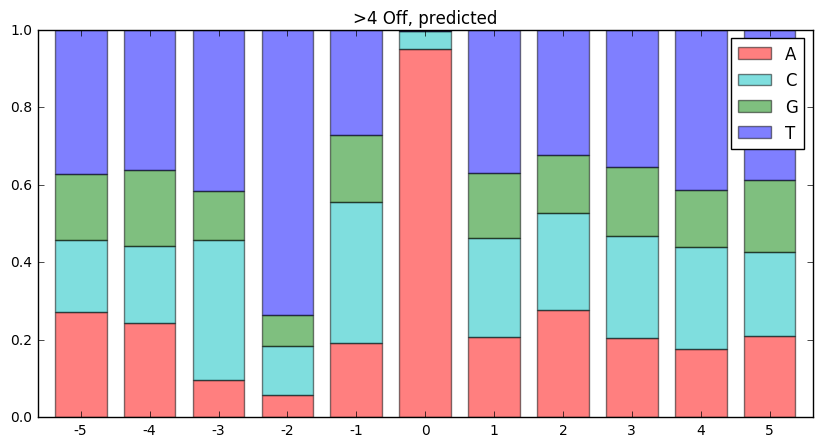

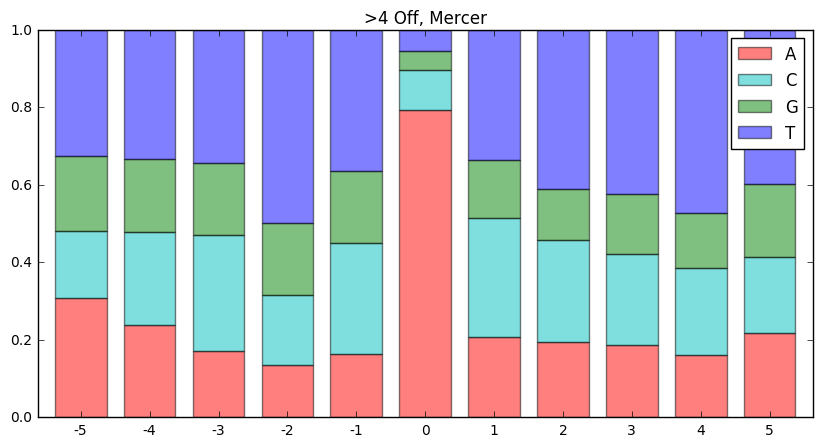

In [23]:
B, E = -4, 4
pwm(test_preds, y_high_test, y_low_test,
    lambda x,y,z: match(x,y), use_pred,
    'Match')
pwm(test_preds, y_high_test, y_low_test,
    lambda x,y,z: match(x,z), use_pred,
    'Match Low Conf')
pwm(test_preds, y_high_test, y_low_test,
    lambda x,y,z: close(x, y) and not (match(x,y) or match(x,z)),
    use_pred,
    '<4 Off, predicted')
pwm(test_preds, y_high_test, y_low_test,
    lambda x,y,z: close(x, y) and not (match(x,y) or match(x,z)),
    use_mercer,
    '<4 Off, Mercer')
pwm(test_preds, y_high_test, y_low_test,
    lambda x,y,z: not (close(x, y) or match(x,y) or match(x,z)),
    use_pred,
    '>4 Off, predicted')
pwm(test_preds, y_high_test, y_low_test,
    lambda x,y,z: not (close(x, y) or match(x,y) or match(x,z)),
    use_mercer,
    '>4 Off, Mercer')

# Counts by number we are off

[20, 23, 24, 39, 50, 56, 80, 39, 87, 116, 3234, 74, 60, 69, 76, 64, 62, 30, 37, 27]


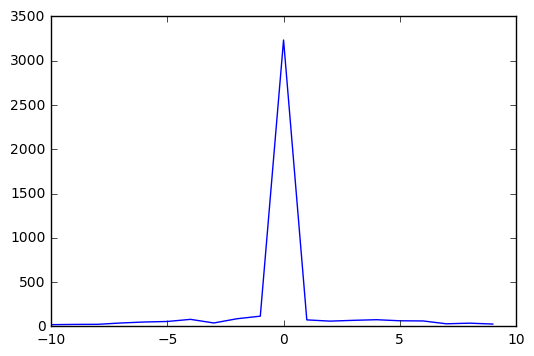

[80, 63, 90, 85, 179, 136, 169, 213, 325, 614, 408, 292, 170, 155, 111, 83, 125, 158, 102, 33]


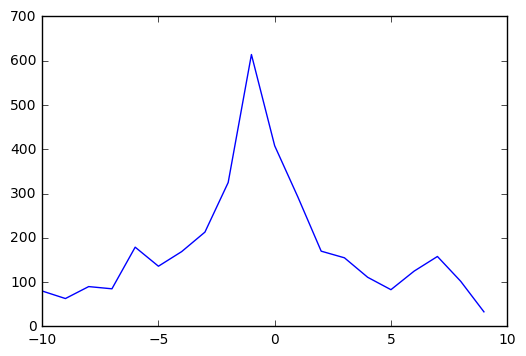

[25, 23, 26, 45, 46, 58, 71, 39, 37, 31, 3642, 26, 59, 61, 75, 65, 58, 37, 33, 27]


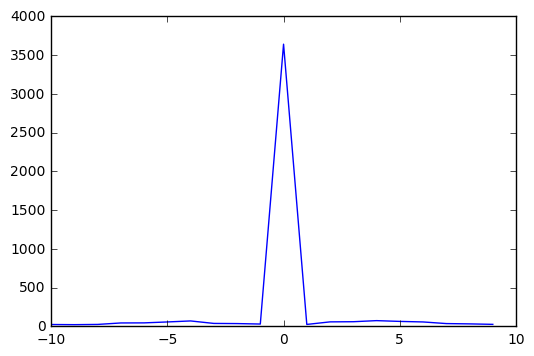

In [29]:
def shift(preds, y):
    match = []
    for offset in range(-10, 10):
        match += [0]
        for p, t in zip(preds, y):
            if offset != 0 and np.argmax(p) in np.nonzero(t)[0]: continue
            if np.argmax(p)+offset in np.nonzero(t)[0]:
                match[-1] += 1
    print match
    plt.plot(range(-10, 10), match)
    plt.show()

shift(test_preds, y_high_test)
shift(test_preds, y_low_test)
shift(test_preds, y_low_test+y_high_test)

# More fine grained shift analysis

20


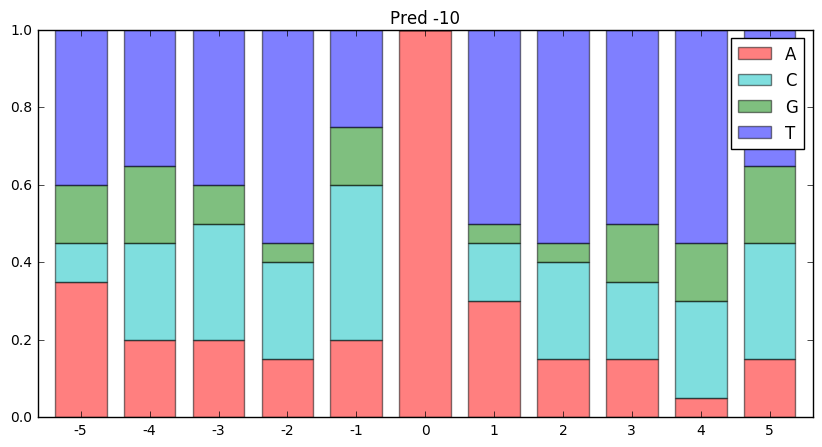

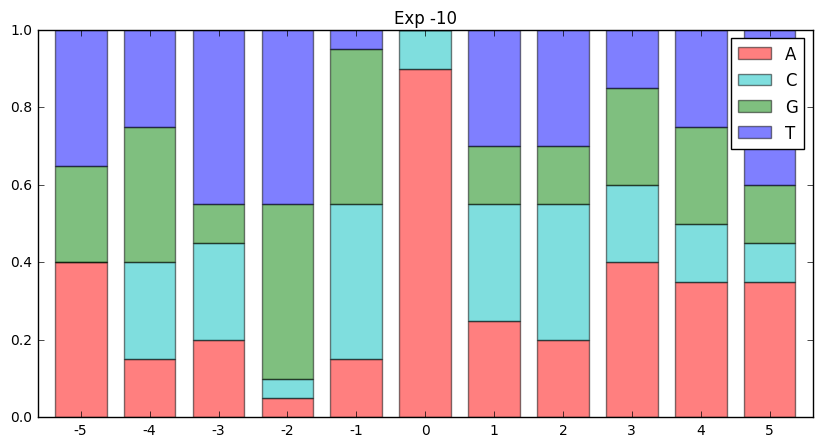

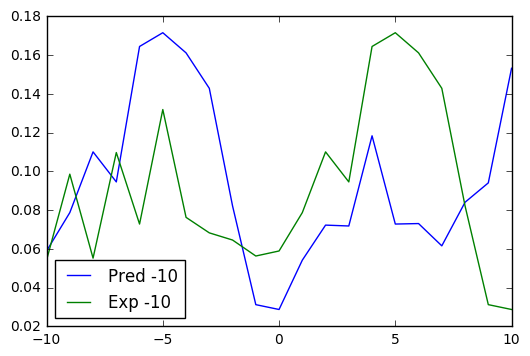

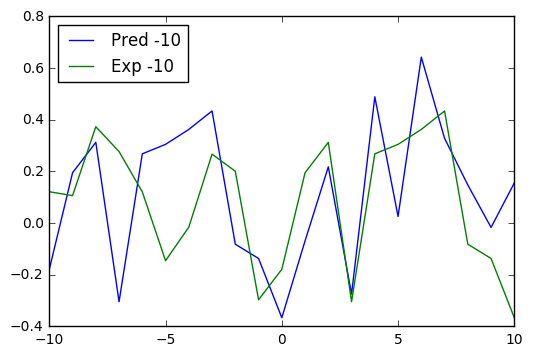

23


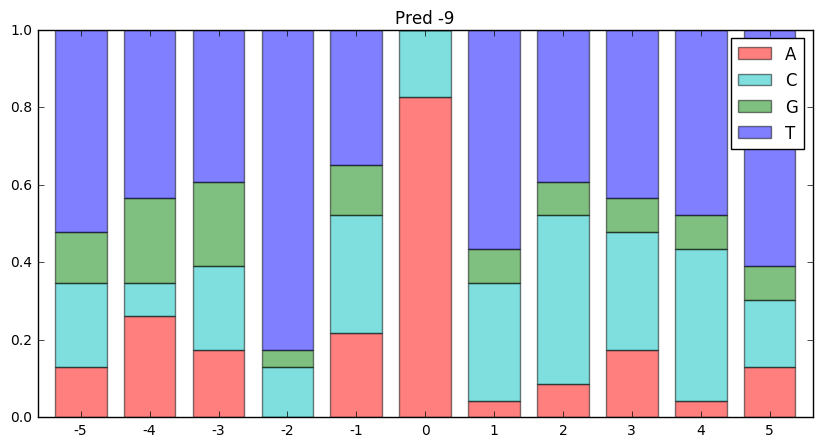

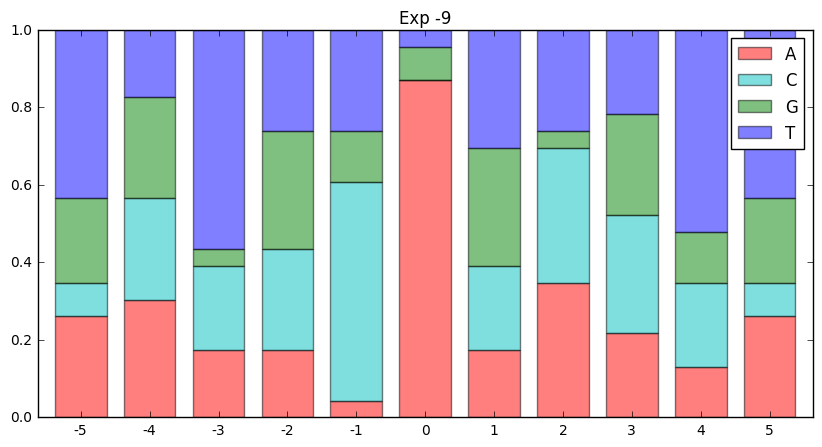

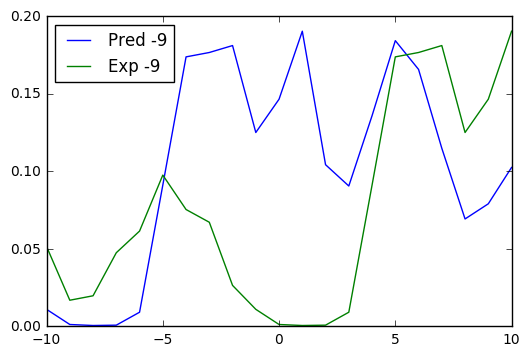

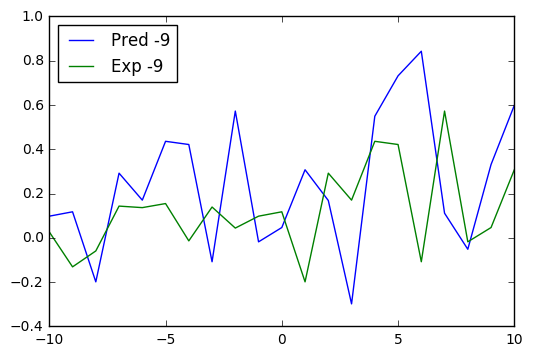

24


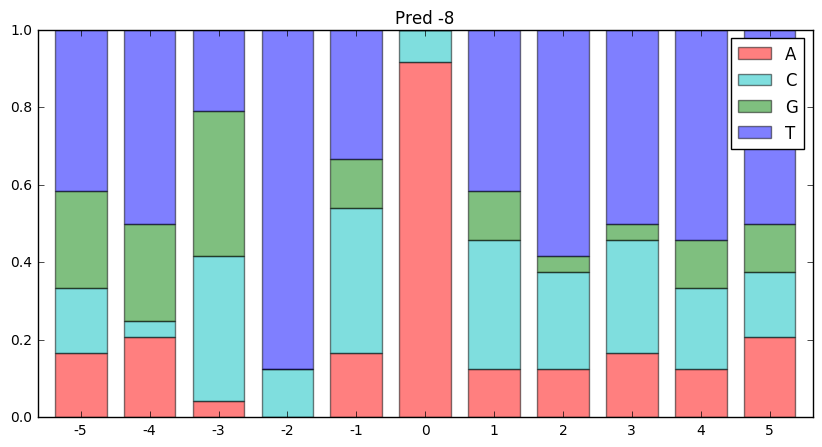

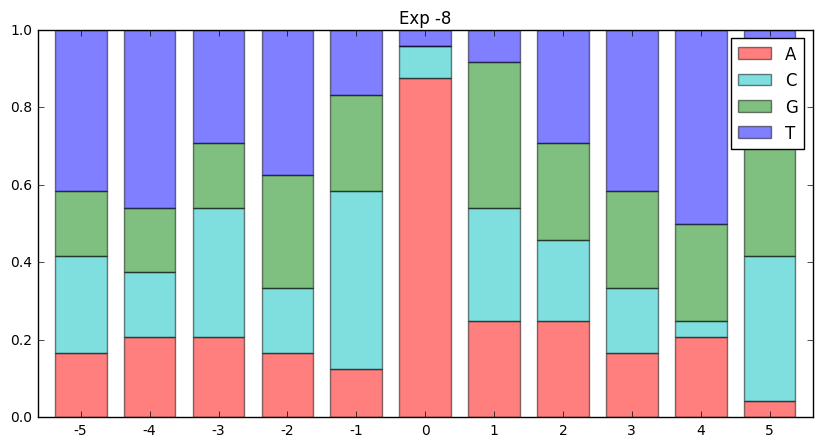

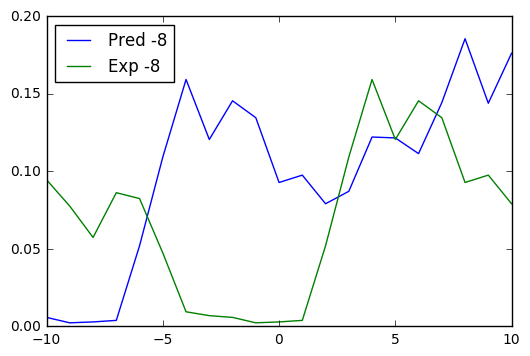

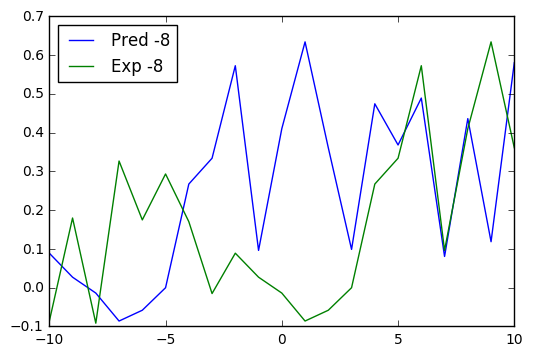

39


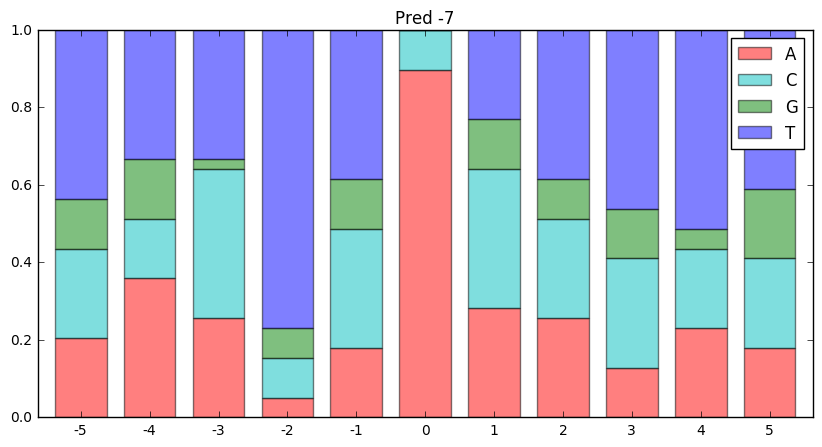

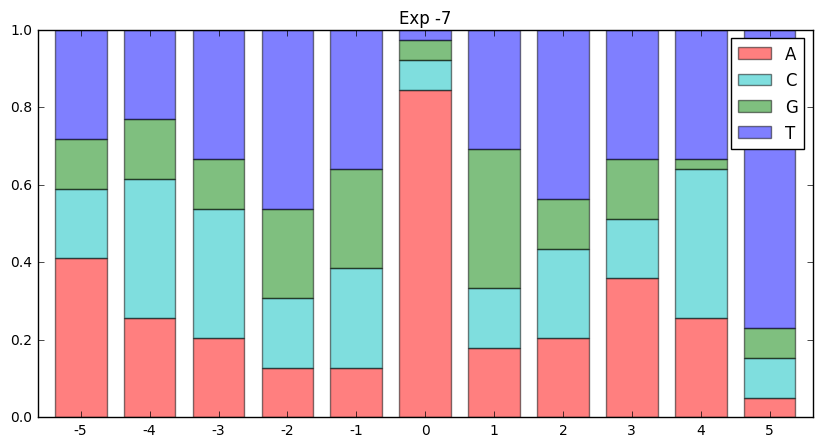

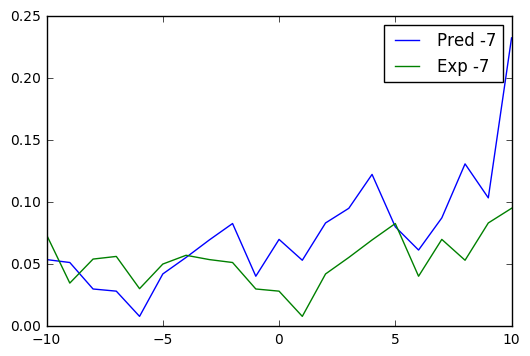

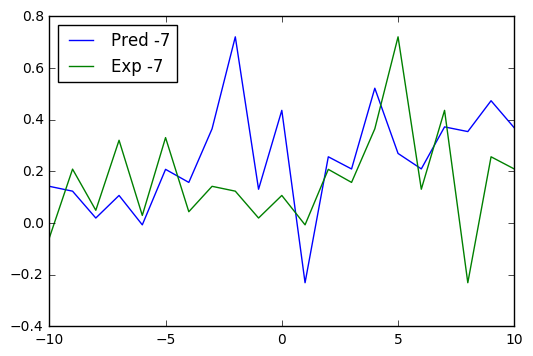

50


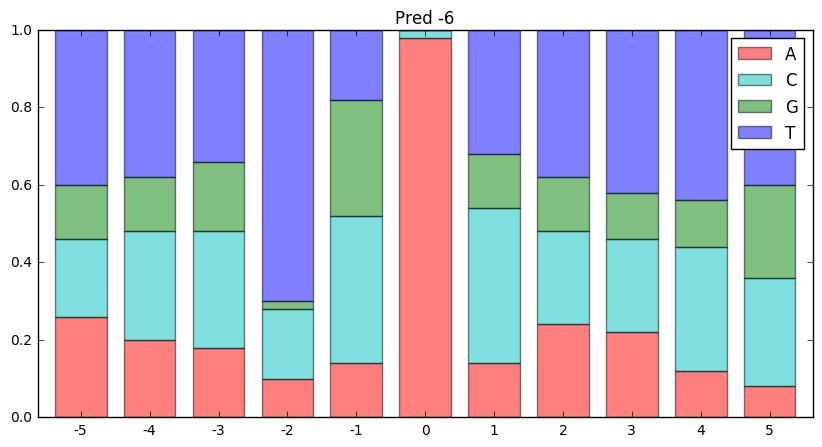

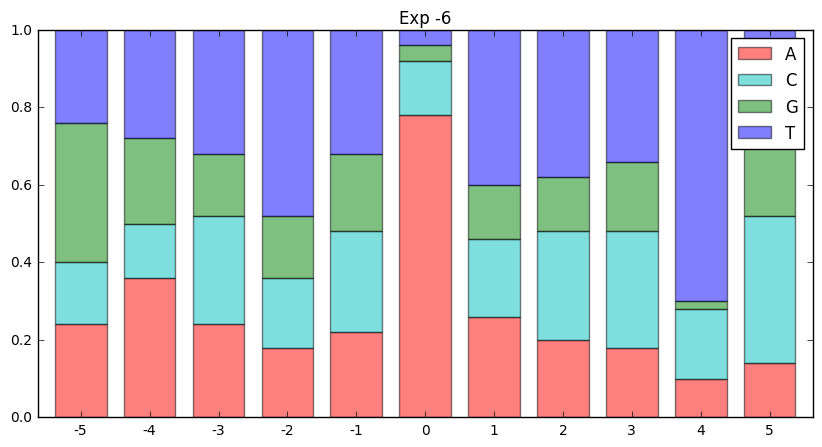

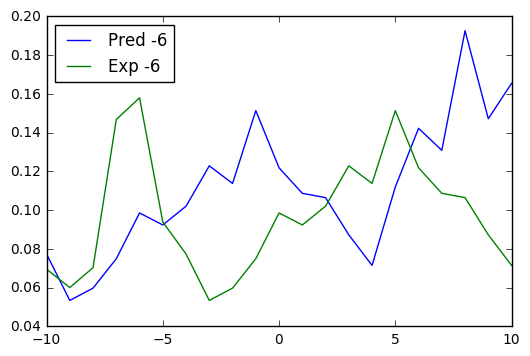

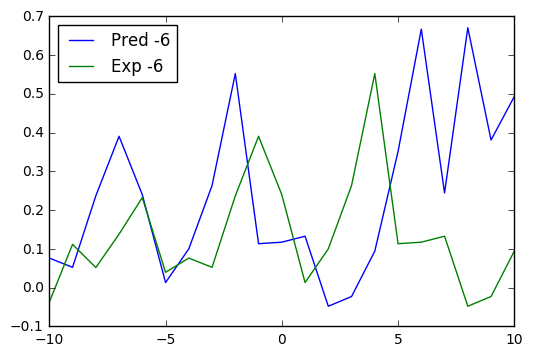

56


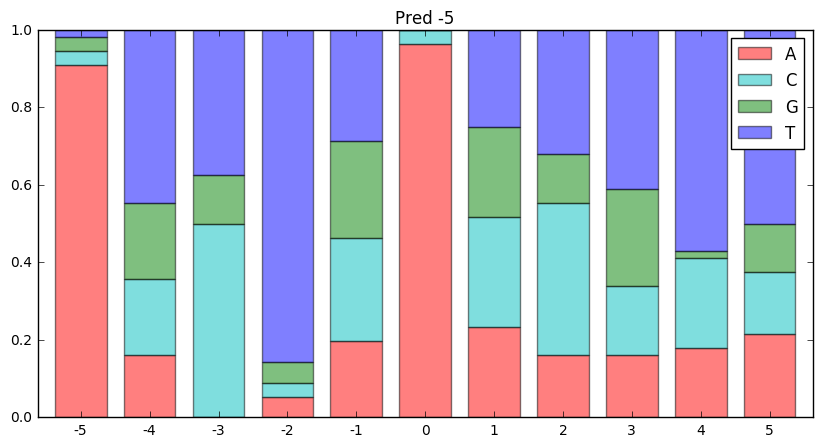

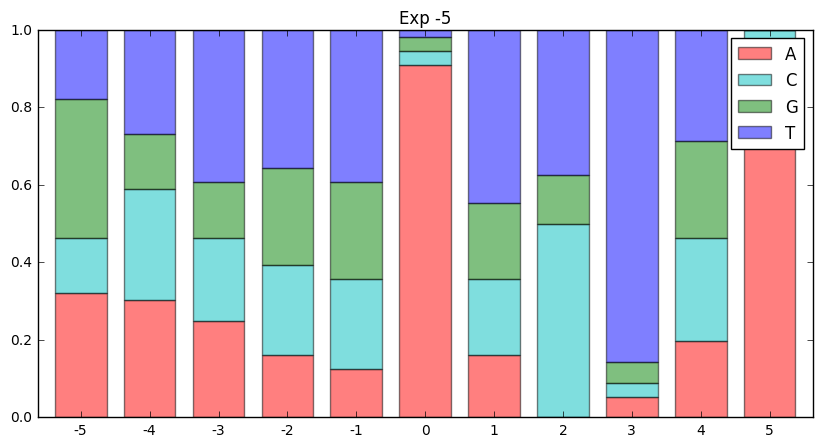

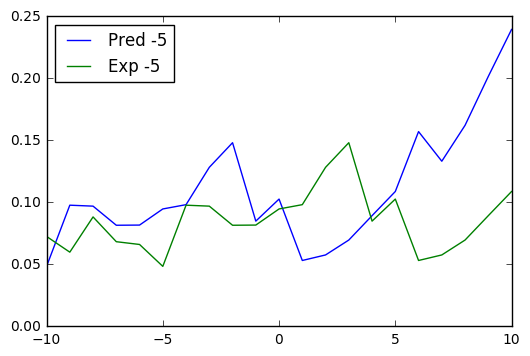

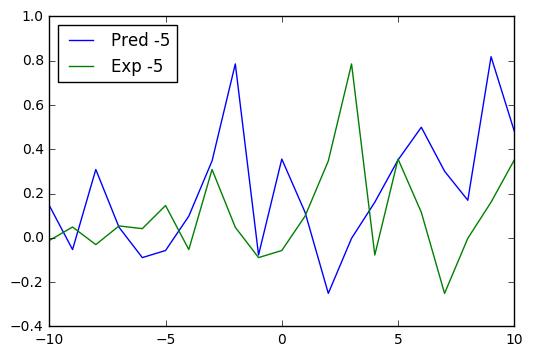

80


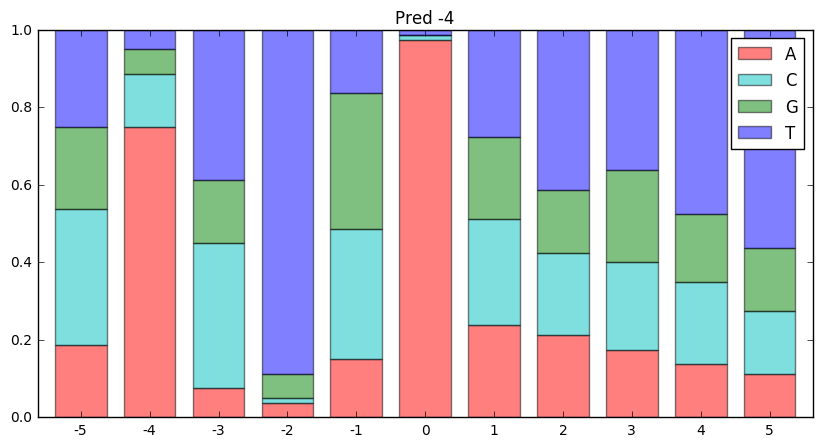

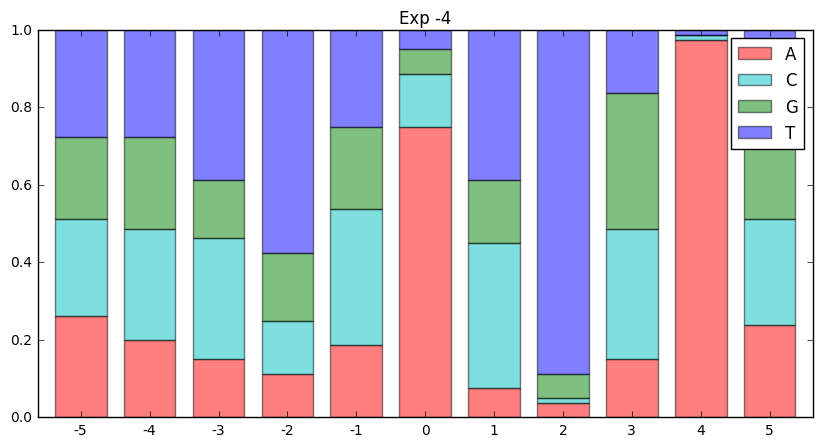

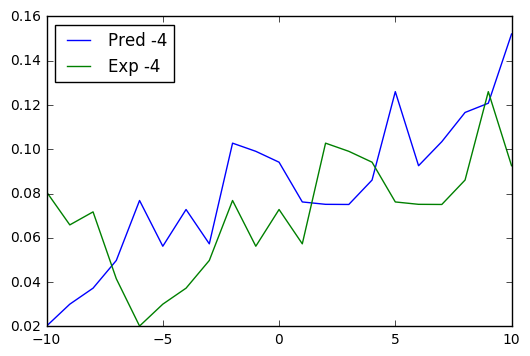

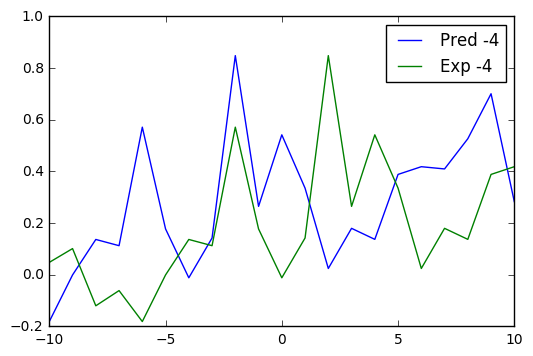

39


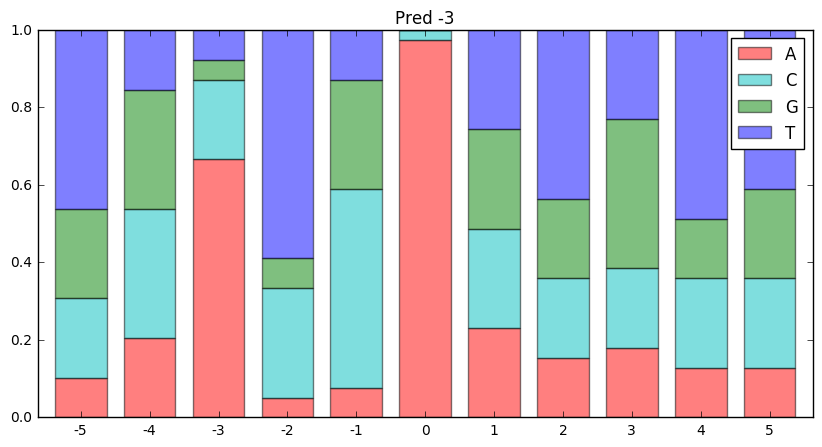

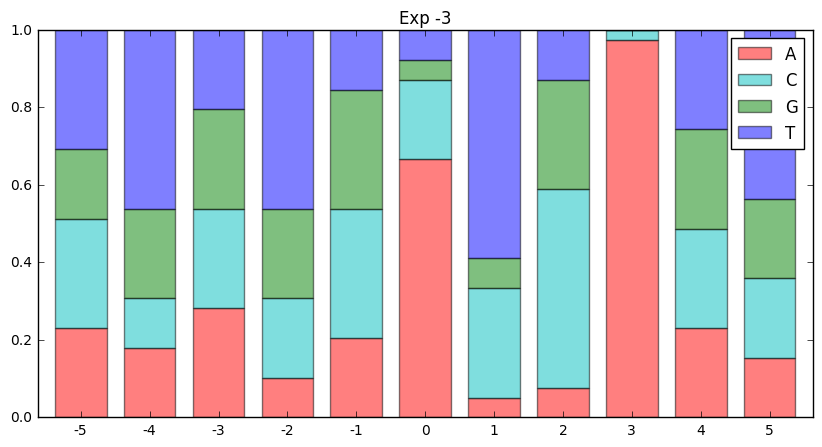

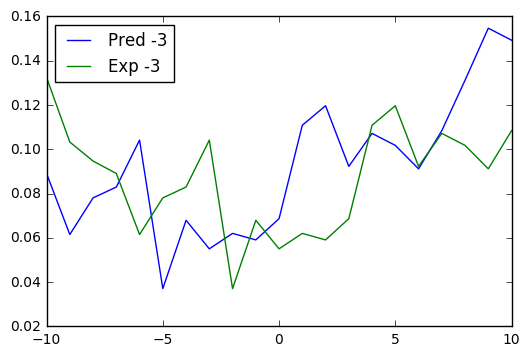

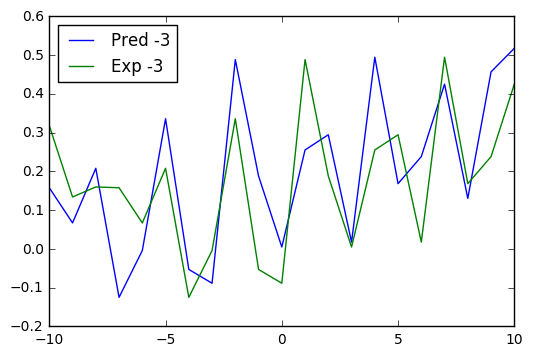

87


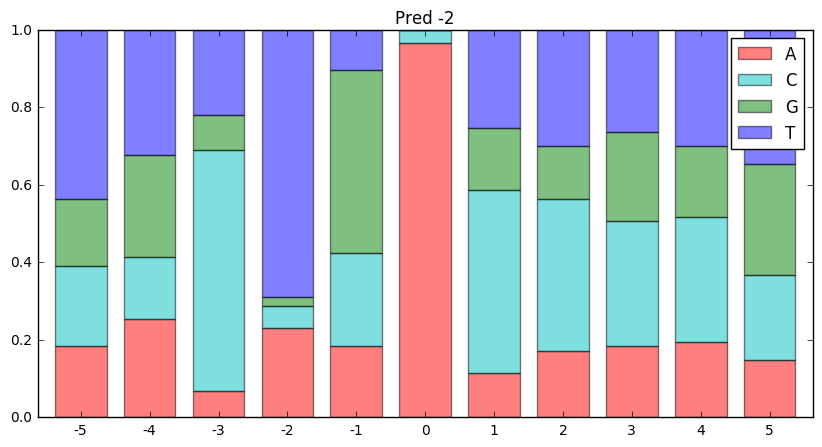

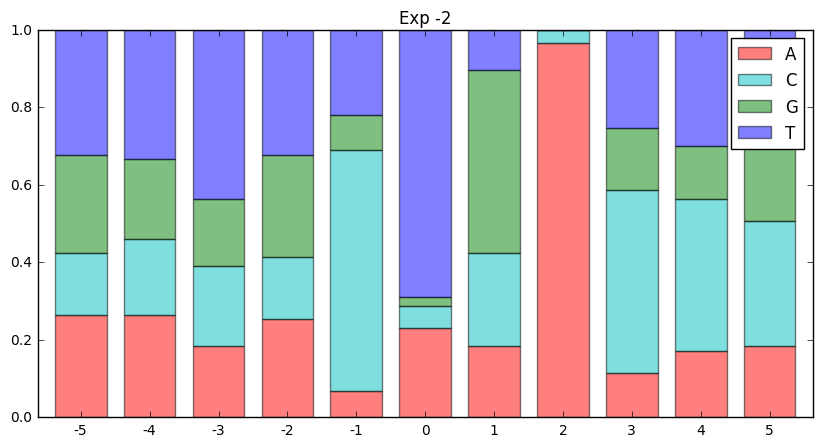

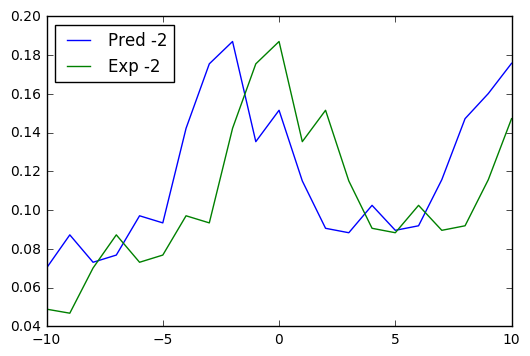

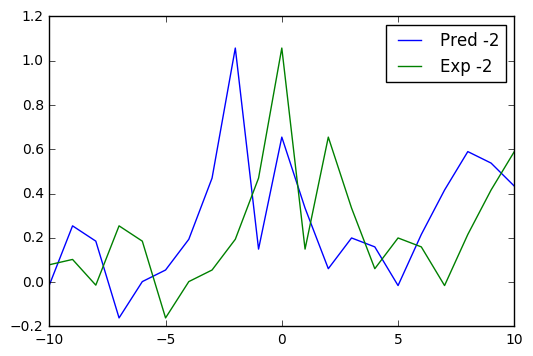

115


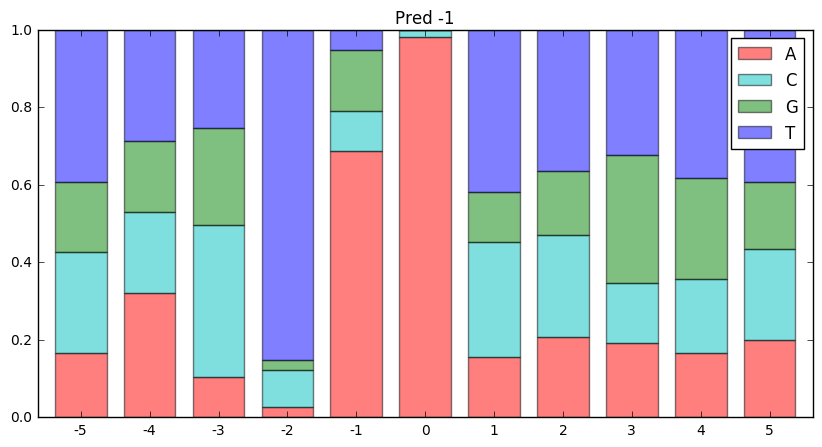

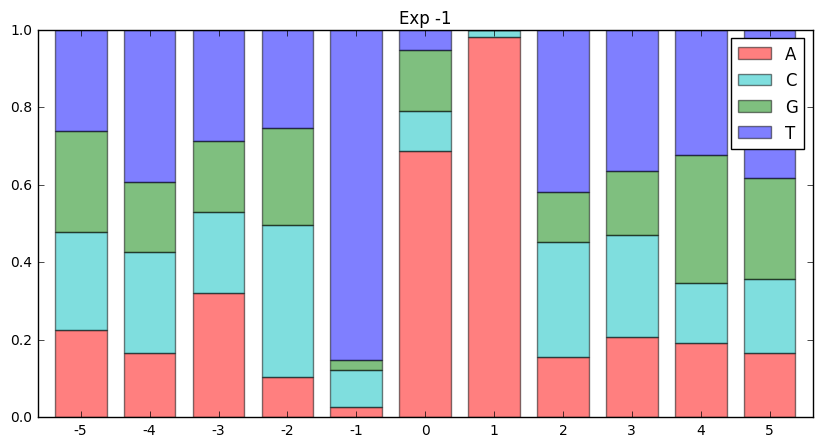

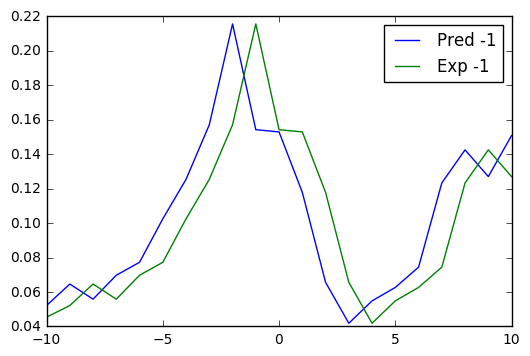

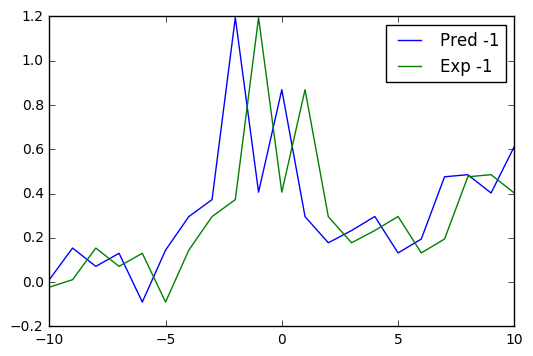

0


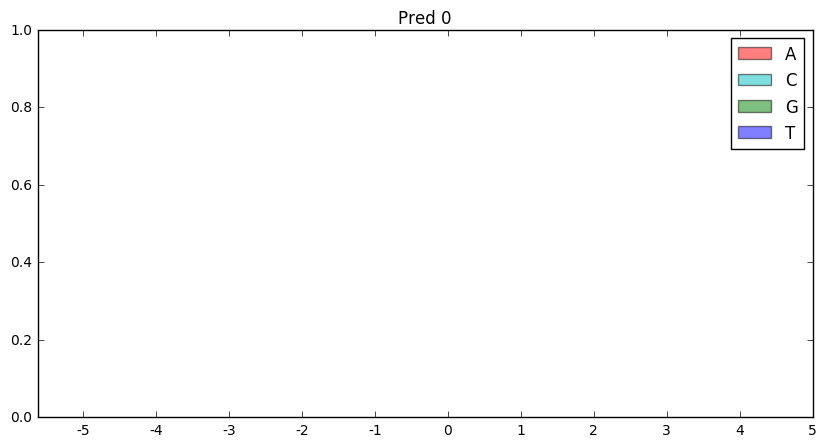

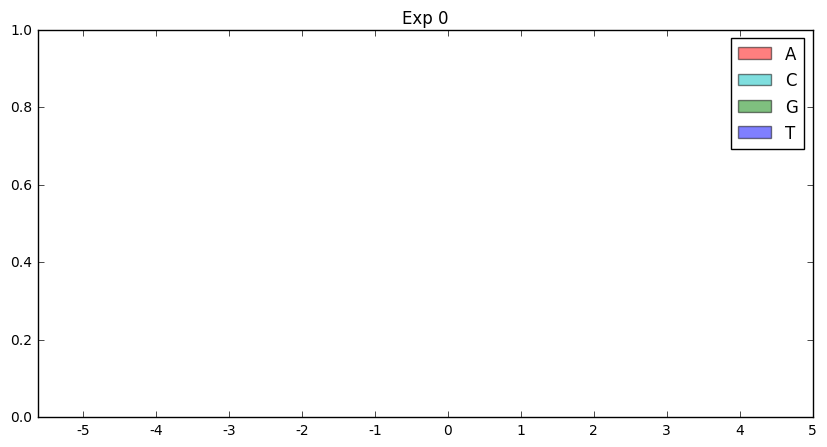

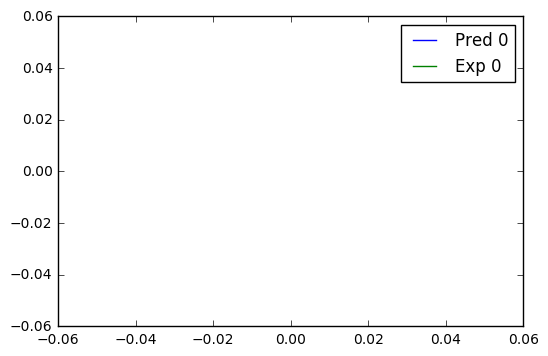

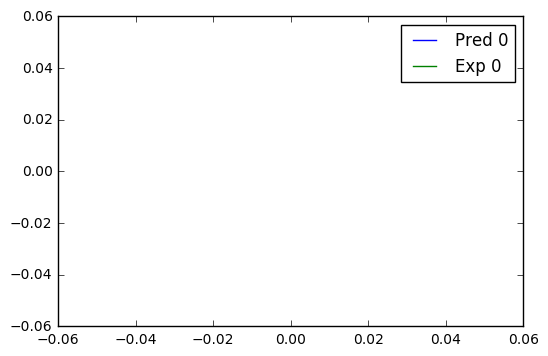

74


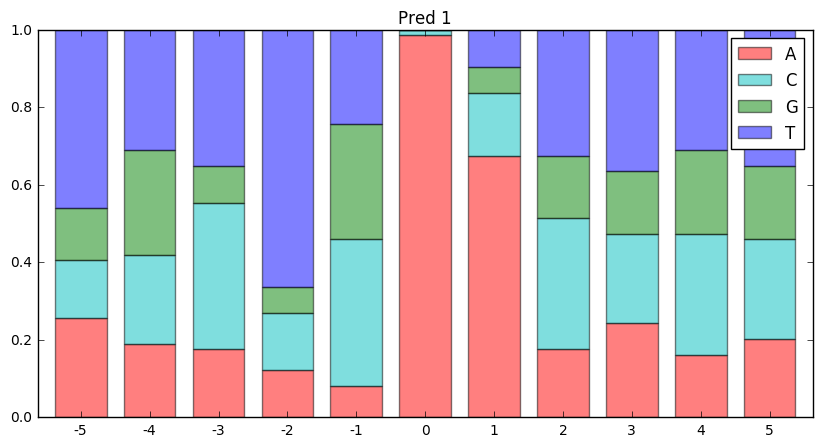

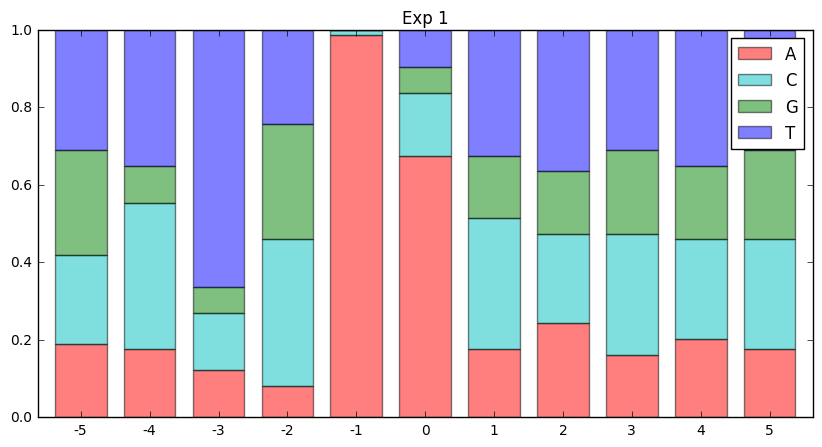

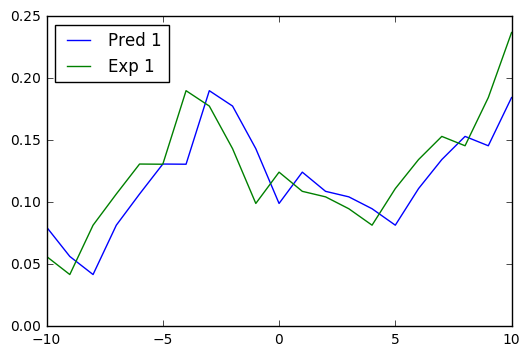

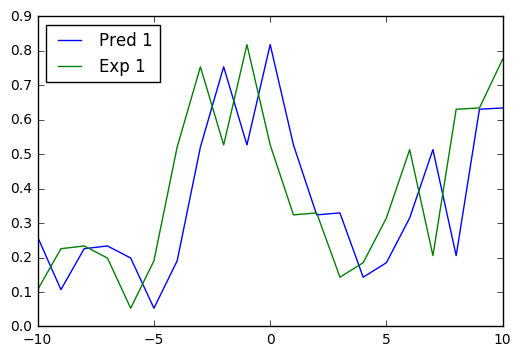

60


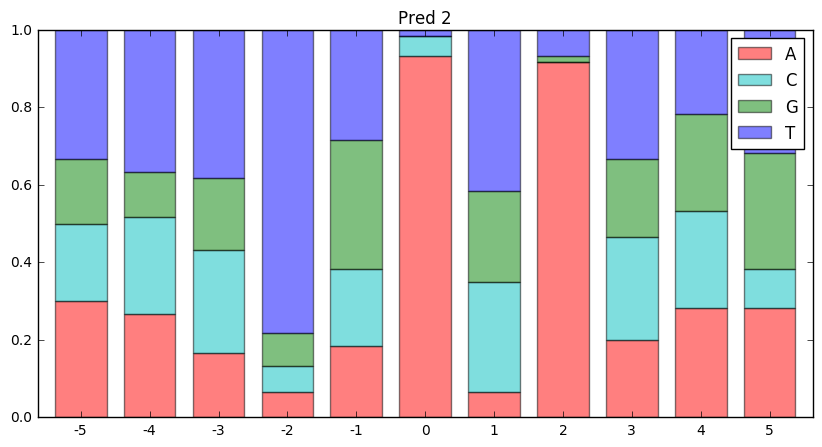

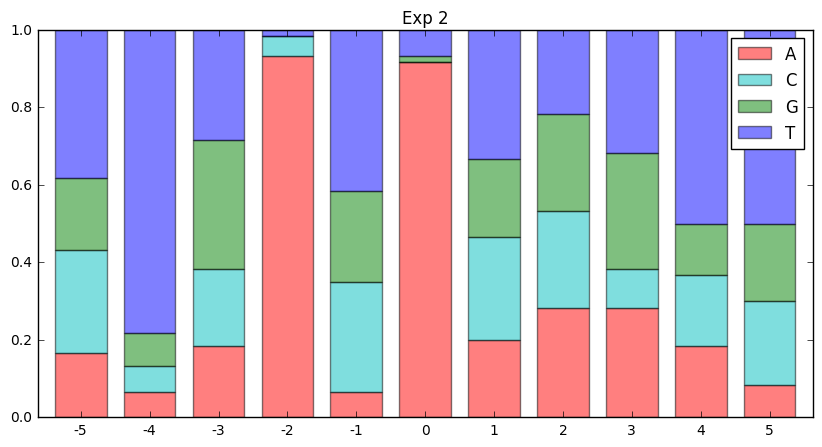

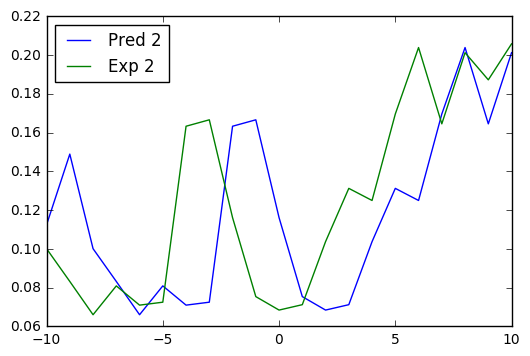

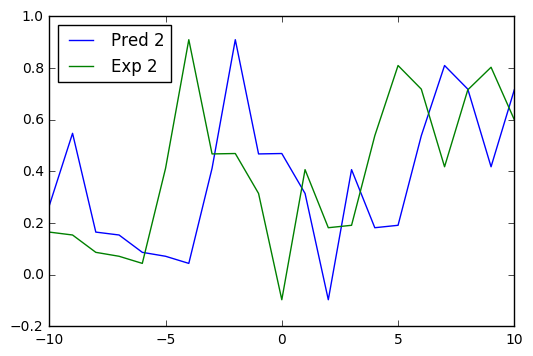

69


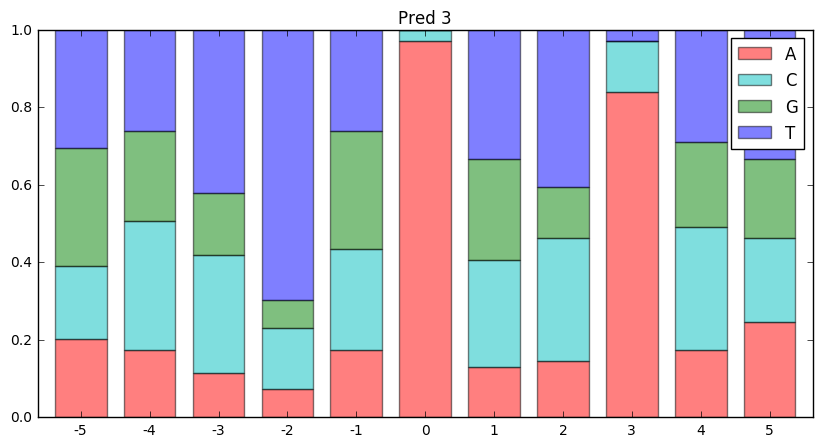

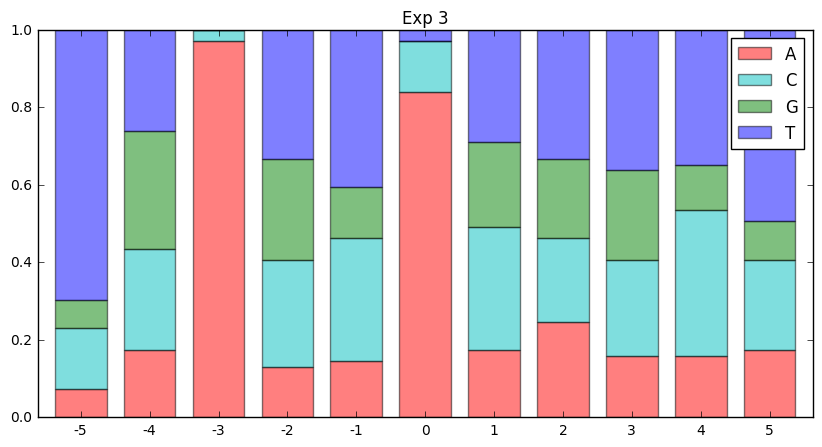

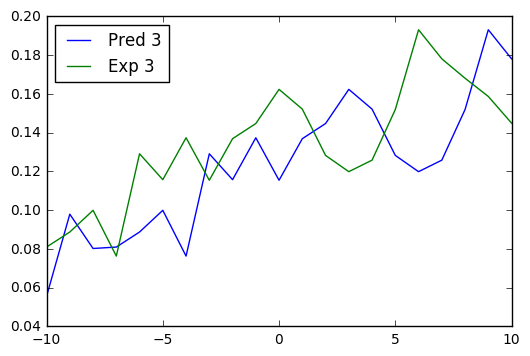

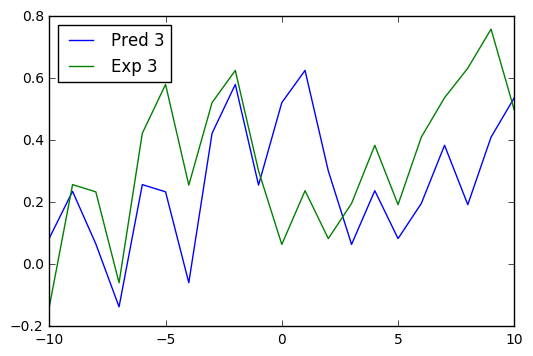

76


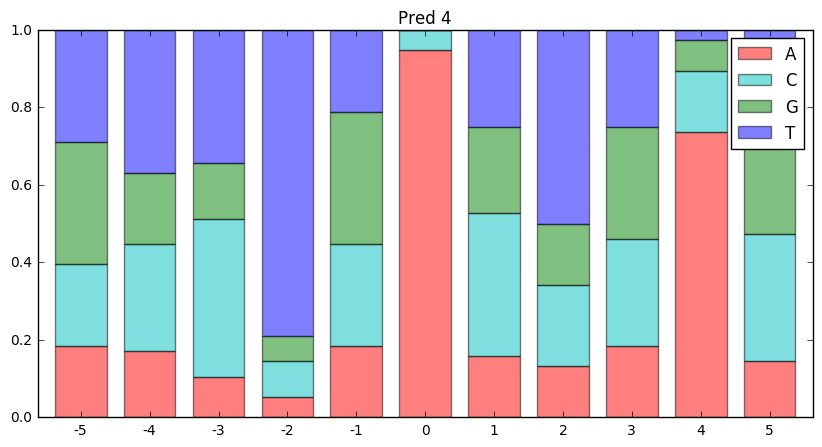

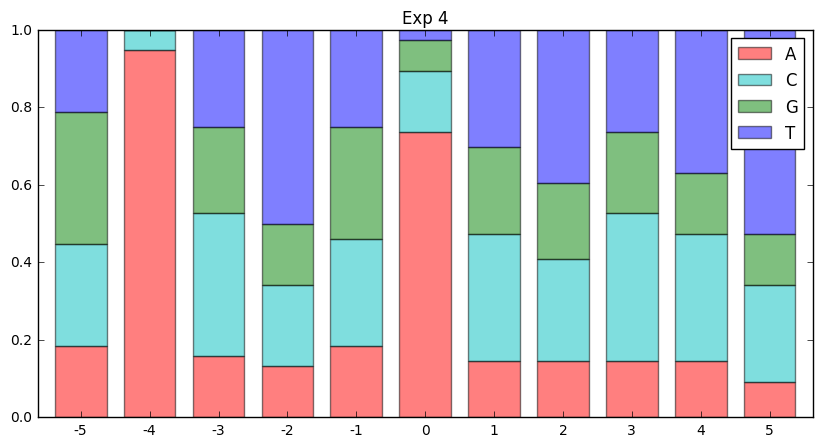

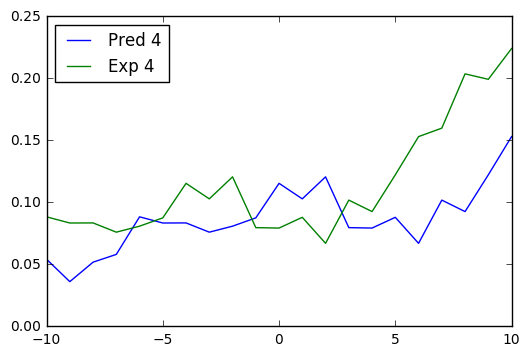

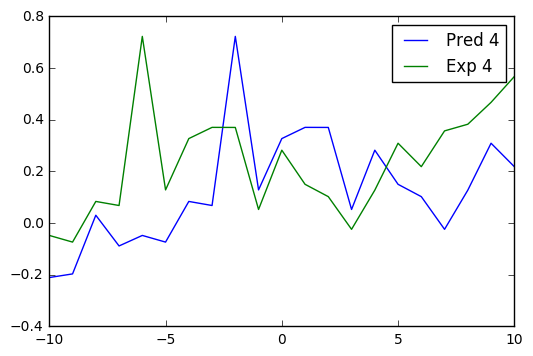

64


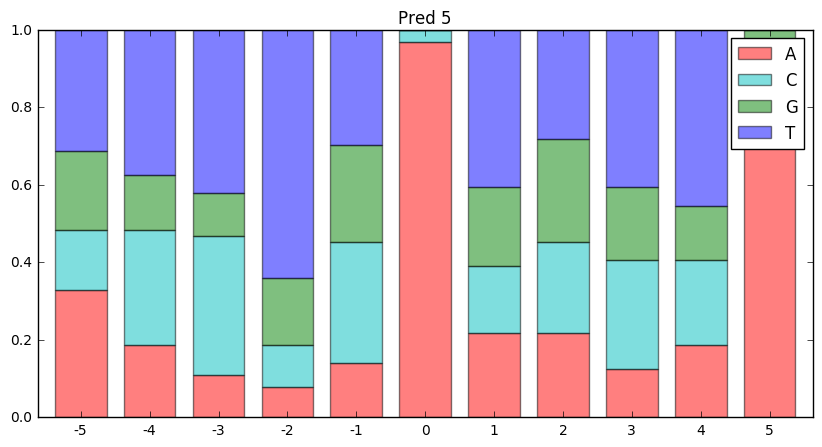

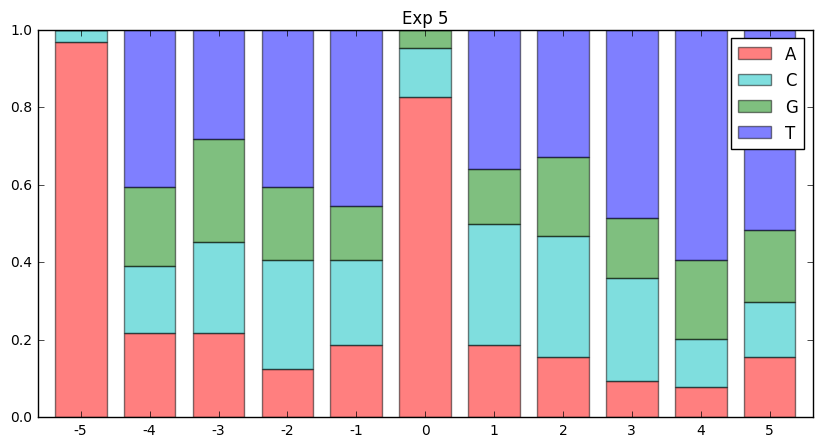

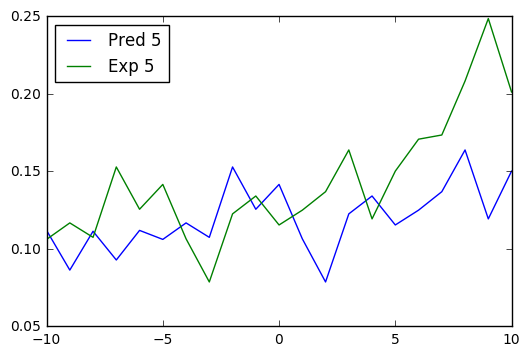

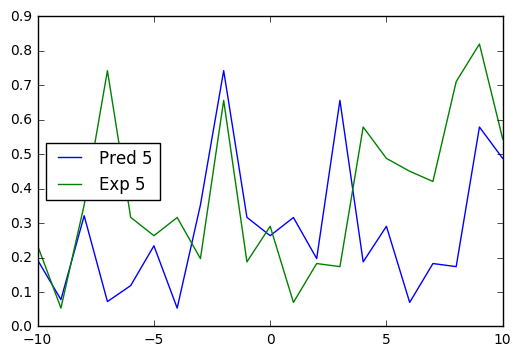

62


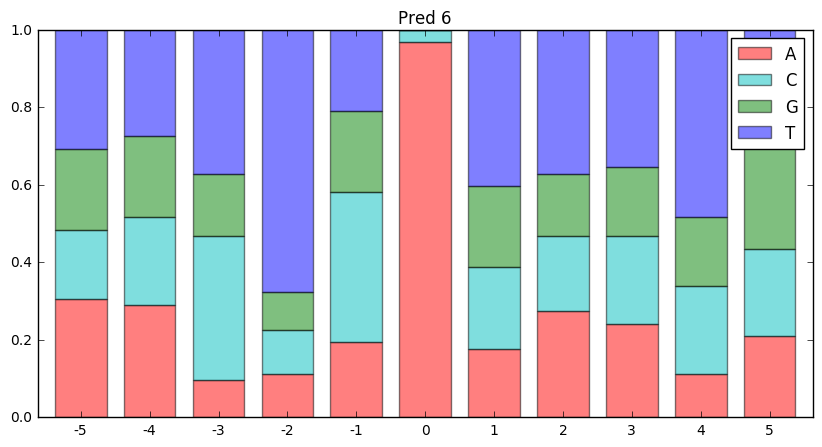

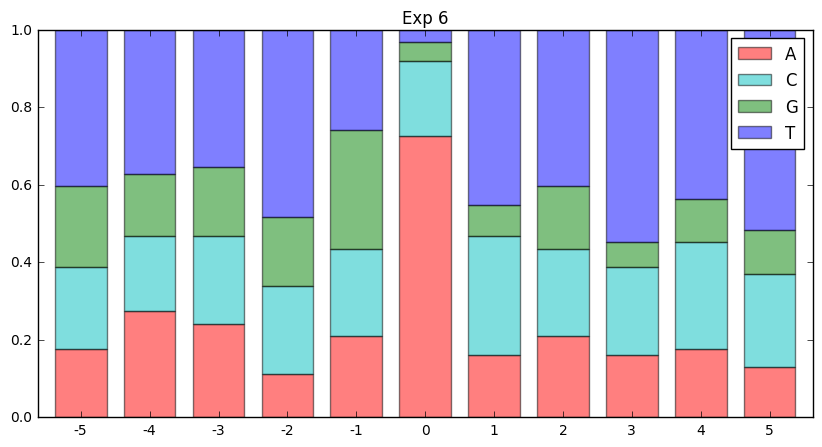

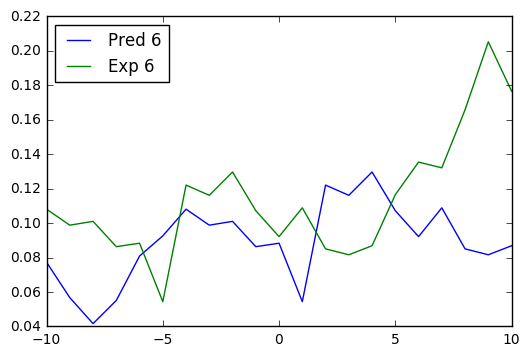

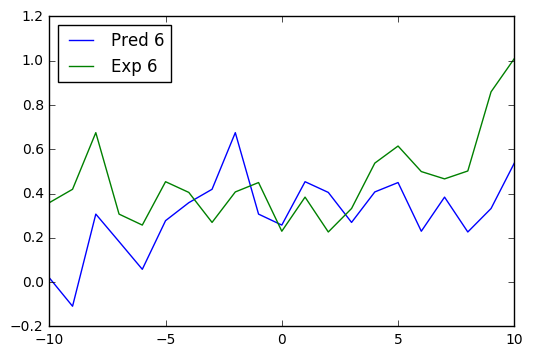

30


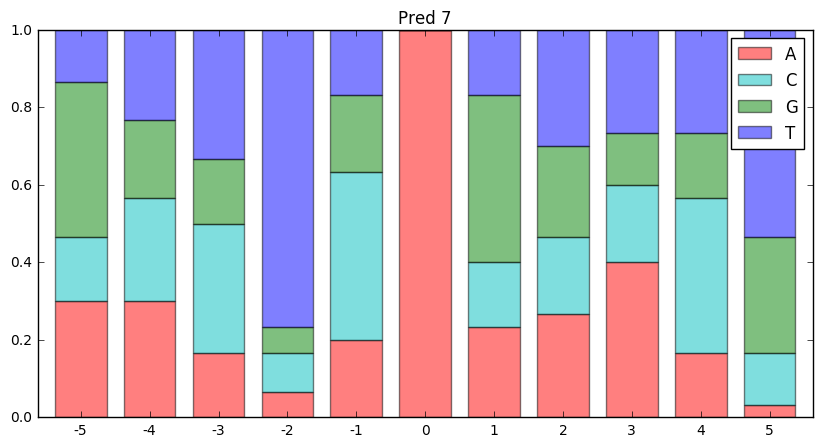

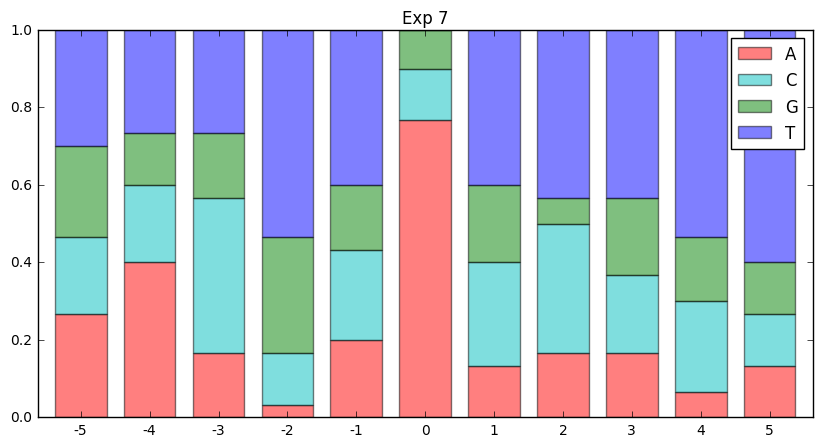

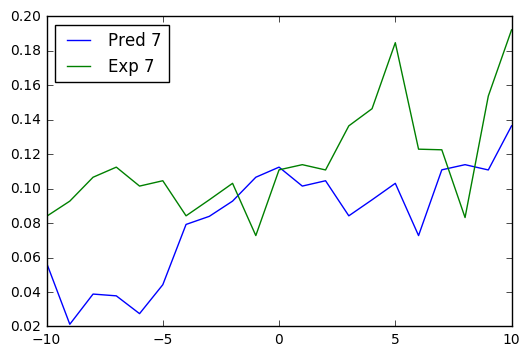

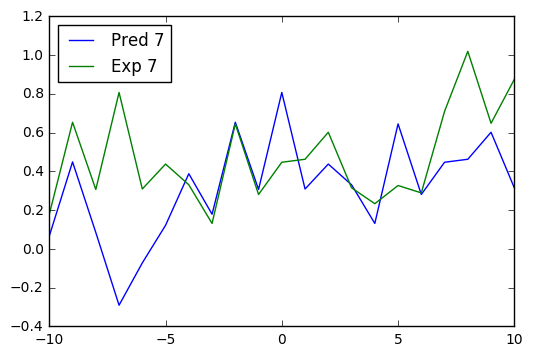

37


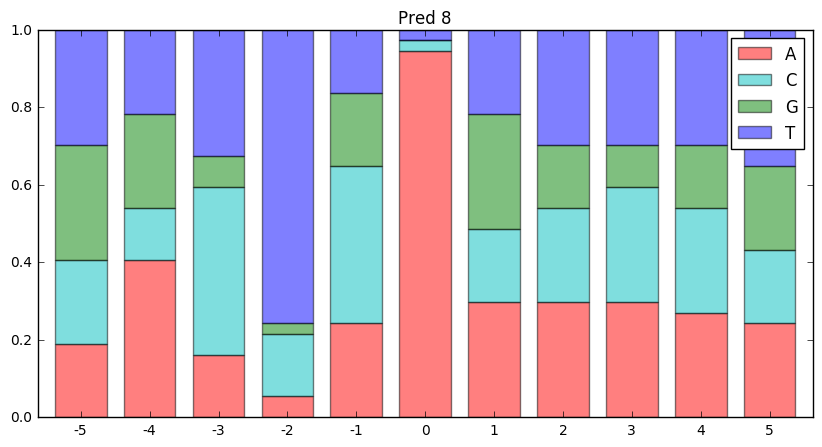

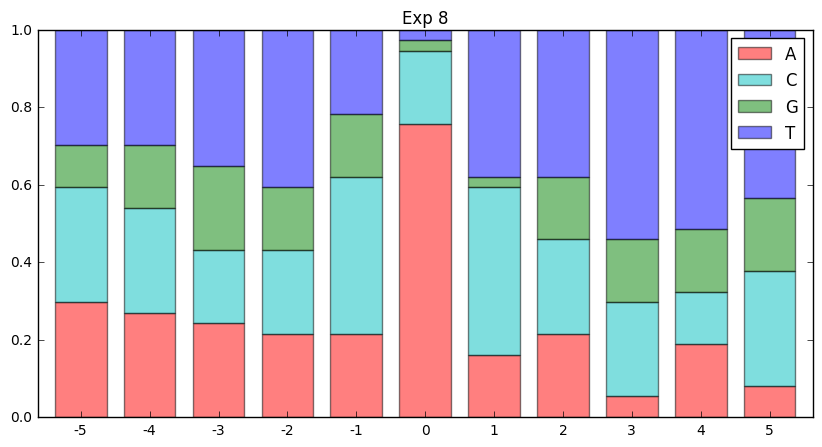

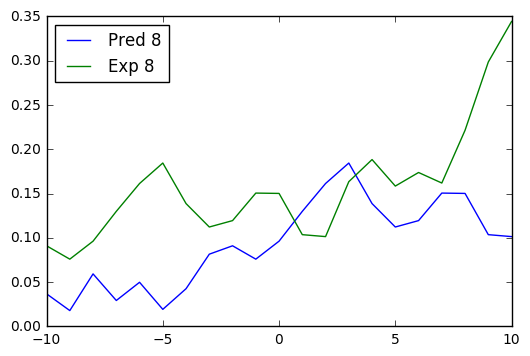

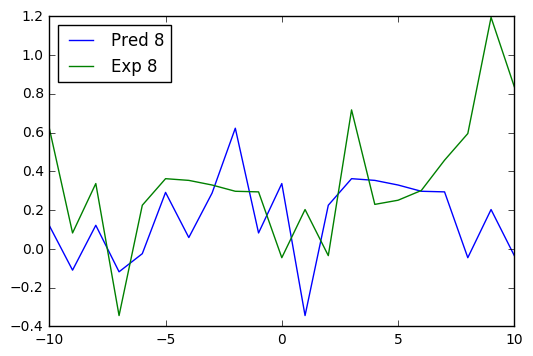

27


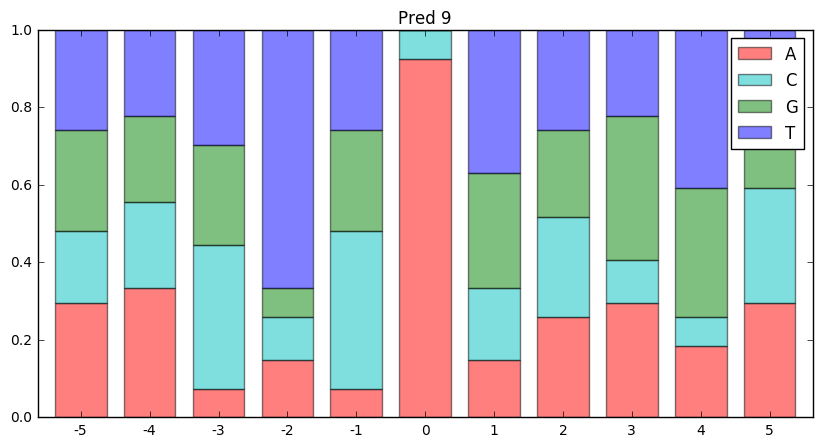

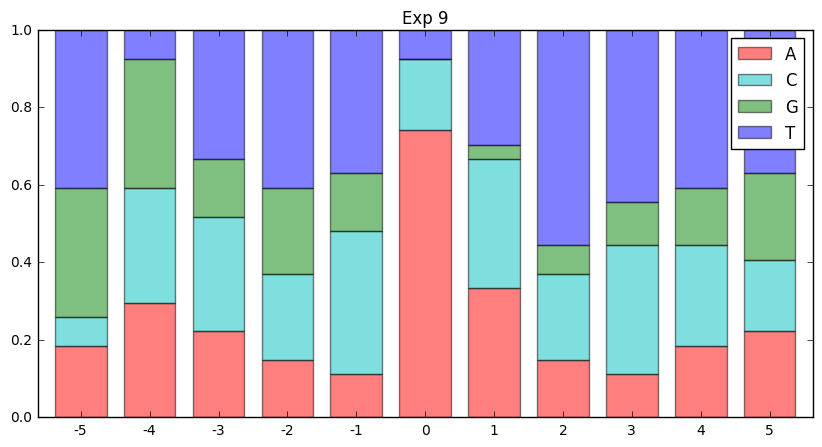

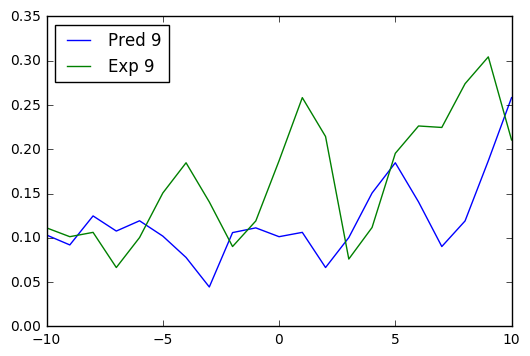

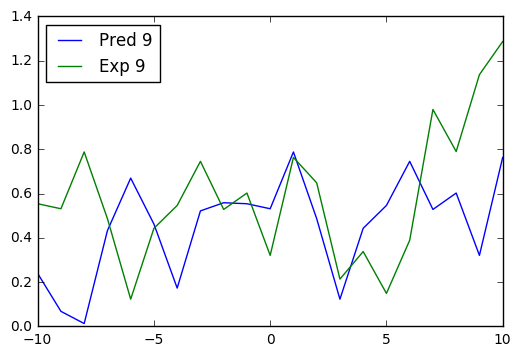

In [24]:
# For each shift, build a pwm centered on prediction
K, C = 5, 10
for offset in range(-10, 10):
    counts1 = np.zeros((2*K+1, 4))
    counts2 = np.zeros((2*K+1, 4))
    phcons1 = np.zeros((2*C+1,))
    phcons2 = np.zeros((2*C+1,))
    phylop1 = np.zeros((2*C+1,))
    phylop2 = np.zeros((2*C+1,))
    total = 0
    for p, t, seq in zip(test_preds, y_high_test, X_test):
        if np.argmax(p) in np.nonzero(t)[0]: continue
        if np.argmax(p)+offset in np.nonzero(t)[0]:
            bp = np.argmax(p)
            if 0 > bp-C or bp+C+1 > seq.shape[0]: continue
            counts1 = counts1 + seq[bp-K: bp+K+1, :4]
            phcons1 = phcons1 + seq[bp-C:bp+C+1, 4]
            phylop1 = phylop1 + seq[bp-C:bp+C+1, 5]
            
            bp = np.argmax(p)+offset
            if 0 > bp-C or bp+C+1 > seq.shape[0]: continue
            counts2 = counts2 + seq[bp-K: bp+K+1, :4]
            phcons2 = phcons2 + seq[bp-C:bp+C+1, 4]
            phylop2 = phylop2 + seq[bp-C:bp+C+1, 5]
            
            total += 1
    print total
    pwm_logo(counts1 / total, "Pred {}".format(offset))
    pwm_logo(counts2 / total, "Exp {}".format(offset))
    plt.plot(range(-C, C+1), phcons1 / total, label = "Pred {}".format(offset))
    plt.plot(range(-C, C+1), phcons2 / total, label = "Exp {}".format(offset))
    plt.legend(loc = 'best')
    plt.show()
    plt.plot(range(-C, C+1), phylop1 / total, label = "Pred {}".format(offset))
    plt.plot(range(-C, C+1), phylop2 / total, label = "Exp {}".format(offset))
    plt.legend(loc = 'best')
    plt.show()